In [479]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
 
import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

import lightgbm as lgb
 
import scipy

import statsmodels.api
import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os

In [234]:
os.listdir("data")

['dangjin_fcst_data.csv',
 'dangjin_obs_data.csv',
 'energy.csv',
 'sample_submission.csv',
 'site_info.csv',
 'ulsan_fcst_data.csv',
 'ulsan_obs_data.csv']

# 1. Data Load

In [235]:
dangjin_fcst = pd.read_csv("data/dangjin_fcst_data.csv")
dangjin_obs = pd.read_csv("data/dangjin_obs_data.csv")
energy = pd.read_csv("data/energy.csv")
site_info = pd.read_csv("data/site_info.csv")
ulsan_fcst = pd.read_csv("data/ulsan_fcst_data.csv")
ulsan_obs = pd.read_csv("data/ulsan_obs_data.csv")

## 1) 데이터 준비

### (1) Forecast Time 변환

In [236]:
dangjin_fcst["forecast"] = pd.to_datetime(dangjin_fcst["Forecast time"]) + dangjin_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

In [237]:
ulsan_fcst["forecast"] = pd.to_datetime(ulsan_fcst["Forecast time"]) + ulsan_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

# 2. EDA

## 1) 기초 통계 및 결측, 이상치 확인

### (1) 결측치

In [28]:
print(dangjin_fcst.isna().apply(lambda x : x.value_counts()))
print(dangjin_obs.isna().apply(lambda x : x.value_counts()))
print(energy.isna().apply(lambda x : x.value_counts()))
print(site_info.isna().apply(lambda x : x.value_counts()))
print(ulsan_fcst.isna().apply(lambda x : x.value_counts()))
print(ulsan_obs.isna().apply(lambda x : x.value_counts()))

       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud  
False         162208  162208  
            지점      지점명       일시  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  전운량(10분위)
False  25626.0  25626.0  25626.0   25589    25590     25590  25591      21656
True       NaN      NaN      NaN      37       36        36     35       3970
          time  dangjin_floating  dangjin_warehouse  dangjin    ulsan
False  25632.0             25608              25584  25632.0  25632.0
True       NaN                24                 48      NaN      NaN
       Id  Capacity  Address  InstallationAngle  IncidentAngle  Latitude  \
False   4         4        4                  4              4         4   

       Longitude  
False          4  
       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud 

Forecast엔 결측치가 없고, obs엔 결측치가 소수 존재한다. Energy 결측치는 이유에 대한 탐색이 필요해보인다.

#### - Energy 결측 탐색

In [35]:
energy.loc[energy["dangjin_warehouse"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
384,2018-03-17 1:00:00,0.0,NaN,0,0
385,2018-03-17 2:00:00,0.0,NaN,0,0
386,2018-03-17 3:00:00,0.0,NaN,0,0
387,2018-03-17 4:00:00,0.0,NaN,0,0
388,2018-03-17 5:00:00,0.0,NaN,0,0
389,2018-03-17 6:00:00,0.0,NaN,0,0
390,2018-03-17 7:00:00,0.0,NaN,0,0
391,2018-03-17 8:00:00,24.0,NaN,16,13
392,2018-03-17 9:00:00,162.0,NaN,177,57
393,2018-03-17 10:00:00,363.0,NaN,348,206


In [36]:
energy.loc[energy["dangjin_floating"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
20352,2020-06-26 1:00:00,NaN,0.0,0,0
20353,2020-06-26 2:00:00,NaN,0.0,0,0
20354,2020-06-26 3:00:00,NaN,0.0,0,0
20355,2020-06-26 4:00:00,NaN,0.0,0,0
20356,2020-06-26 5:00:00,NaN,0.0,0,0
20357,2020-06-26 6:00:00,NaN,0.0,0,0
20358,2020-06-26 7:00:00,NaN,7.0,2,7
20359,2020-06-26 8:00:00,NaN,20.0,18,50
20360,2020-06-26 9:00:00,NaN,148.0,175,161
20361,2020-06-26 10:00:00,NaN,242.0,330,170


Enegry 내부에선 상관성이 있는 변수가 없어보인다.

정확히 하루 단위로 데이터가 NA이므로, 삭제해도 무방할 것으로 판단됨

In [43]:
energy = energy.dropna().reset_index(drop = True)

#### - obs 결측 탐색

In [47]:
dangjin_obs.isna().apply(lambda x : x.value_counts())

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
False,25626.0,25626.0,25626.0,25589,25590,25590,25591,21656
True,NaN,NaN,NaN,37,36,36,35,3970


In [100]:
dangjin_fcst[dangjin_fcst["Forecast time"] == '2019-01-31 11:00:00']

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
49728,2019-01-31 11:00:00,2019-01-31 15:00:00,-1.0,40.0,9.0,328.0,4.0
49729,2019-01-31 11:00:00,2019-01-31 18:00:00,-3.0,45.0,9.2,323.0,3.0
49730,2019-01-31 11:00:00,2019-01-31 21:00:00,-3.0,50.0,10.9,320.0,3.0
49731,2019-01-31 11:00:00,2019-02-01 00:00:00,-4.0,50.0,10.1,319.0,2.0
49732,2019-01-31 11:00:00,2019-02-01 03:00:00,-2.0,60.0,8.8,320.0,3.0
49733,2019-01-31 11:00:00,2019-02-01 06:00:00,-2.0,70.0,5.9,318.0,3.0
49734,2019-01-31 11:00:00,2019-02-01 09:00:00,-2.0,70.0,2.9,252.0,3.0
49735,2019-01-31 11:00:00,2019-02-01 12:00:00,2.0,45.0,7.5,284.0,2.0
49736,2019-01-31 11:00:00,2019-02-01 15:00:00,4.0,45.0,8.1,275.0,2.0
49737,2019-01-31 11:00:00,2019-02-01 18:00:00,1.0,65.0,7.5,269.0,1.0


In [101]:
dangjin_obs[dangjin_obs["일시"].str.slice(0,10) == '2019-01-31']

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
8058,129,서산,2019-01-31 00:00,1.4,0.1,0.0,85.0,10.0
8059,129,서산,2019-01-31 01:00,1.3,0.4,0.0,87.0,10.0
8060,129,서산,2019-01-31 02:00,2.3,1.3,20.0,88.0,10.0
8061,129,서산,2019-01-31 03:00,1.8,1.0,20.0,80.0,10.0
8062,129,서산,2019-01-31 04:00,1.6,2.5,360.0,56.0,10.0
8063,129,서산,2019-01-31 05:00,1.0,1.9,360.0,51.0,10.0
8064,129,서산,2019-01-31 06:00,0.6,1.4,360.0,48.0,10.0
8065,129,서산,2019-01-31 07:00,0.3,2.9,360.0,48.0,10.0
8066,129,서산,2019-01-31 08:00,-0.3,2.4,360.0,45.0,10.0
8067,129,서산,2019-01-31 09:00,-0.6,2.7,360.0,44.0,10.0


기온, 풍속, 풍향, 습도 결측치는 서로 밀접한 연관이 있는 것으로 보인다.

활용이 불가능하므로 제외한다.

In [204]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

### - 전운량 결측 탐색

In [211]:
dangjin_obs["전운량(10분위)"].isna().value_counts()

False    21618
True      3970
Name: 전운량(10분위), dtype: int64

In [273]:
dangjin_obs["date"] = dangjin_obs["forecast"].dt.date
dangjin_obs["hour"] = dangjin_obs["date"].astype("str") + " " + dangjin_obs["forecast"].dt.hour.astype("str")

<AxesSubplot:>

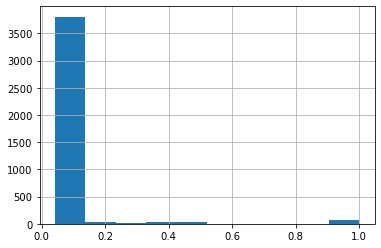

In [274]:
# 하루 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("date").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

최초 예상으로는 전운량이 Na인 경우 하루 전체가 다 그럴것이라는 가설을 세웠지만

그 가설은 사실이 아닌것으로 판명되었다.

<AxesSubplot:>

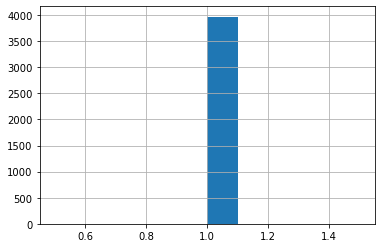

In [275]:
# 시간 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("hour").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

## 2) 파생 변수 생성 전략 탐색

### (1) obs의 전운량과 fcst의 cloud간 비교 

#### - 데이터 Merge

In [22]:
dangjin_obs = dangjin_obs.rename(columns = {"일시" : "forecast"})

dangjin_obs["forecast"] = pd.to_datetime(dangjin_obs["forecast"])

In [313]:
result = pd.merge(dangjin_obs, dangjin_fcst, on = "forecast", how = "left")

#### - 상관계수

In [314]:
result[["Cloud","전운량(10분위)"]].corr()

,Cloud,전운량(10분위)
Cloud,1.000000,0.493646
전운량(10분위),0.493646,1.000000


상관도가 생각보다 낮다. 예측과 실제값 사이에 괴리감이 큰 것으로 보인다.

#### - 오차값(잔차) 확인

잔차를 확인하면 이를 이용하여 예측값에서 실제 정답값을 유사하게라도 보정할 수 있지 않을까?

히스토그램을 그려 잔차가 정규분포를 따르는지 확인하고, 실제 정규성 검정을 수행해본다.

(array([ 6963., 12617., 26617., 33842., 10633.,  8692., 16352., 26363.,
         7278.,  8144.]),
 array([-9. , -7.7, -6.4, -5.1, -3.8, -2.5, -1.2,  0.1,  1.4,  2.7,  4. ]),
 <BarContainer object of 10 artists>)

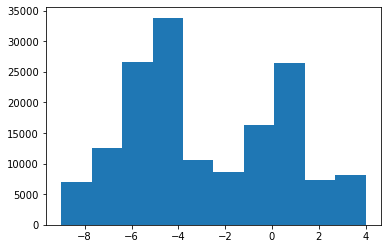

In [315]:
plt.hist(result["Cloud"] - result["전운량(10분위)"])

쌍봉 분포를 보인다. 

차이가 전혀 없는 경우(평균이 0인 정규분포)와 차이가 5~6정도 나는 경우(평균이 5인 정규분포)로 나뉘는 것으로 보인다.

In [316]:
scipy.stats.kstest((result["Cloud"] - result["전운량(10분위)"]).dropna(), "norm")

KstestResult(statistic=0.6081284021563662, pvalue=0.0)

아쉽게도, 잔차는 정규분포를 따르지 않는다.

In [317]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]

,지점,지점명,forecast,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위),date,hour,Forecast time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
78,129,서산,2018-03-02 18:00:00,1.6,1.4,360.0,53.0,6.0,2018-03-02,2018-03-02 18,2018-03-01 11:00:00,1.0,55.0,1.9,264.0,1.0
79,129,서산,2018-03-02 18:00:00,1.6,1.4,360.0,53.0,6.0,2018-03-02,2018-03-02 18,2018-03-01 14:00:00,1.0,55.0,1.9,264.0,1.0
80,129,서산,2018-03-02 18:00:00,1.6,1.4,360.0,53.0,6.0,2018-03-02,2018-03-02 18,2018-03-01 17:00:00,1.0,60.0,1.4,278.0,1.0
81,129,서산,2018-03-02 18:00:00,1.6,1.4,360.0,53.0,6.0,2018-03-02,2018-03-02 18,2018-03-01 20:00:00,1.0,60.0,1.4,278.0,1.0
82,129,서산,2018-03-02 18:00:00,1.6,1.4,360.0,53.0,6.0,2018-03-02,2018-03-02 18,2018-03-01 23:00:00,1.0,60.0,1.4,278.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174529,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-30 02:00:00,6.0,75.0,2.9,180.0,3.0
174538,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 05:00:00,6.0,75.0,3.3,168.0,3.0
174539,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 08:00:00,6.0,75.0,3.3,168.0,3.0
174540,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 11:00:00,6.0,75.0,3.3,168.0,3.0


<AxesSubplot:>

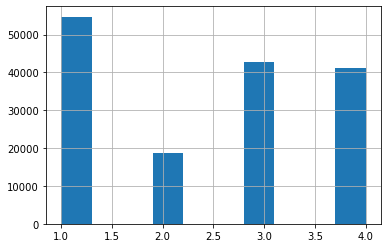

In [318]:
result["Cloud"].hist()

<AxesSubplot:>

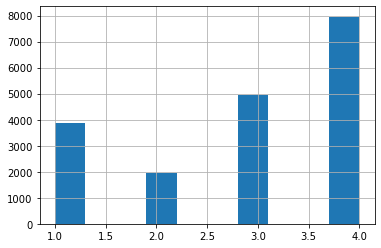

In [319]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["Cloud"].hist()

<AxesSubplot:>

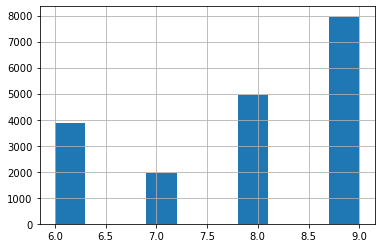

In [320]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["전운량(10분위)"].hist()

전운량의 예측은 1 ~ 4밖에 없다. 

예측 오차가 크게 나는 경우는 실제 전운량이 6 이상으로 나타나는 경우였다.

In [18]:
dangjin_fcst.describe()

,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
count,162208.000000,162208.000000,162208.000000,162208.000000,162208.000000,162208.000000
mean,30.675676,12.624634,76.996147,3.639262,214.147761,2.439411
std,16.714755,9.816256,17.435418,2.627592,108.020035,1.214753
min,4.000000,-14.000000,5.000000,0.000000,0.000000,1.000000
25%,16.000000,4.000000,65.000000,1.900000,115.000000,1.000000
50%,31.000000,13.000000,80.000000,2.800000,237.000000,3.000000
75%,43.000000,21.000000,90.000000,4.600000,313.000000,4.000000
max,67.000000,36.000000,100.000000,32.299999,360.000000,4.000000


## 2) 변수 선별

### (1) 변수 선별용 데이터 전처리

#### - X, y 데이터 생성

In [380]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

In [395]:
energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

In [398]:
energy_obs = pd.merge(energy, dangjin_obs, left_on = "time", right_on = "forecast", how = "left")

In [445]:
energy_obs = energy_obs.dropna().reset_index(drop = True)

energy_obs = energy_obs.drop(["date","hour", "지점", "지점명", "forecast"], axis = 1)

#### - 일출 일몰 정보 생성

In [479]:
def day_night(x):
    if x < 6 or x > 18:
        return 0
    else:
        return 1

In [480]:
energy_obs["day_night"] = energy_obs["time"].dt.hour.apply(lambda x : day_night(int(x)))

### (2) Boruta 알고리즘 활용

In [489]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state = 42)
forest.fit(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]], 
           energy_obs["dangjin_warehouse"].to_numpy())

RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [490]:
from boruta import BorutaPy

feat_selector = BorutaPy(forest, 
                         n_estimators='auto',
                         verbose=2, 
                         random_state=42)

# find all relevant features
feat_selector.fit(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]].to_numpy(), 
                  energy_obs["dangjin_warehouse"].to_numpy())

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]].to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	0


BorutaPy finish

선별된 변수는 없다. 모든 변수를 다 활용할 것이다.

# 3. 데이터 전처리

## 1) 결측값 대체

### (1) 전운량 결측값 대체

#### - MICE 알고리즘

MICE 알고리즘은 결측값을 임의의 평균값으로 대치한 후 OLS를 적합하여

결측값을 해당 OLS 예측값으로 대체한 후 그 예측값으로 다시 OLS를 적합하는 수렴 다중 대체 알고리즘이다.

In [238]:
energy = energy.dropna().reset_index(drop = True)

In [239]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

In [240]:
ulsan_obs = ulsan_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

In [241]:
imput_data = dangjin_obs[dangjin_obs.columns[3:8]]

imput_data.columns = ["temp","windspeed","direction","humidity","cloud"]

imp = sm.imputation.mice.MICEData(imput_data)
# 결측값 대상인 cloud를 적합한다.
imp.set_imputer('cloud')
for j in range(20):
    imp.update_all()
    
dangjin_obs["전운량(10분위)"] = imp.data["cloud"]

In [242]:
imput_data = ulsan_obs[ulsan_obs.columns[3:8]]

imput_data.columns = ["temp","windspeed","direction","humidity","cloud"]

imp = sm.imputation.mice.MICEData(imput_data)
# 결측값 대상인 cloud를 적합한다.
imp.set_imputer('cloud')
for j in range(20):
    imp.update_all()
    
ulsan_obs["전운량(10분위)"] = imp.data["cloud"]

## 2) 파생 변수 생성

### (1) day_night 변수 추가

In [243]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

In [244]:
def day_night(x):
    if x < 5 or x > 19:
        return 0
    else:
        return 1

In [245]:
dangjin_obs = dangjin_obs.rename(columns = {"일시" : "forecast"})

dangjin_obs["forecast"] = pd.to_datetime(dangjin_obs["forecast"])

dangjin_obs["date"] = dangjin_obs["forecast"].dt.date
dangjin_obs["hour"] = dangjin_obs["date"].astype("str") + " " + dangjin_obs["forecast"].dt.hour.astype("str")

dangjin_obs["day_night"] = dangjin_obs["forecast"].dt.hour.apply(lambda x : day_night(int(x)))

energy_obs_dangjin = pd.merge(energy, dangjin_obs, left_on = "time", right_on = "forecast")

energy_obs_dangjin = energy_obs_dangjin.drop(["지점","지점명","forecast","date","hour"], axis = 1)

In [246]:
ulsan_obs = ulsan_obs.rename(columns = {"일시" : "forecast"})

ulsan_obs["forecast"] = pd.to_datetime(ulsan_obs["forecast"])

ulsan_obs["date"] = ulsan_obs["forecast"].dt.date
ulsan_obs["hour"] = ulsan_obs["date"].astype("str") + " " + ulsan_obs["forecast"].dt.hour.astype("str")

ulsan_obs["day_night"] = ulsan_obs["forecast"].dt.hour.apply(lambda x : day_night(int(x)))

energy_obs_ulsan = pd.merge(energy, ulsan_obs, left_on = "time", right_on = "forecast")

energy_obs_ulsan = energy_obs_ulsan.drop(["지점","지점명","forecast","date","hour"], axis = 1)

### (2) 월 변수 추가

#### - dangjin

In [247]:
temp = pd.get_dummies(energy_obs_dangjin["time"].dt.month)

In [248]:
energy_obs_dangjin = pd.concat([energy_obs_dangjin, temp], axis = 1)

#### - ulsan

In [249]:
temp = pd.get_dummies(energy_obs_ulsan["time"].dt.month)

In [250]:
energy_obs_ulsan = pd.concat([energy_obs_ulsan, temp], axis = 1)

# 4. 모델링

## 1) train_test 분할

### (1) 당진 분할

In [251]:
temp = DataFrame(energy_obs_dangjin["time"].dt.date)

In [252]:
def gen():
    n = 0
    while True:
        n += 1
        yield n
        
num = gen()

In [253]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_obs_dangjin["date"] = energy_obs_dangjin["time"].dt.date

energy_obs_dangjin = pd.merge(energy_obs_dangjin, temp)

k = energy_obs_dangjin.groupby("num").apply(lambda x : len(x) / 24)

k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_obs_dangjin = pd.merge(k_full, 
         energy_obs_dangjin,
         how = "left")

train_num = np.random.choice(energy_obs_dangjin["num"].unique(),
              size = int(len(energy_obs_dangjin["num"].unique()) * 0.75),
                replace = False)

test_num = np.array(list(set(energy_obs_dangjin["num"].unique()).difference(set(train_num))))

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_obs_dangjin)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_obs_dangjin)

X_train_dangjin = train[["기온(°C)", 
                         "풍속(m/s)", 
                         "풍향(16방위)", 
                         "습도(%)", 
                         "전운량(10분위)", 
                         "day_night",
                         1,
                         2,
                         3,
                         4,
                         5,
                         6,
                         7,
                         8,
                         9,
                         10,
                         11,
                         12,
                         "num"]]

X_train_dangjin = X_train_dangjin.groupby('num').apply(lambda x : x[["기온(°C)", 
                                                                     "풍속(m/s)", 
                                                                     "풍향(16방위)", 
                                                                     "습도(%)", 
                                                                     "전운량(10분위)",
                                                                     1,
                                                                     2,
                                                                     3,
                                                                     4,
                                                                     5,
                                                                     6,
                                                                     7,
                                                                     8,
                                                                     9,
                                                                     10,
                                                                     11,
                                                                     12,                                                                   
                                                                     "day_night"]].to_numpy())

X_test_dangjin = test[["기온(°C)", 
                       "풍속(m/s)", 
                       "풍향(16방위)", 
                       "습도(%)", 
                       "전운량(10분위)", 
                       "day_night",
                         1,
                         2,
                         3,
                         4,
                         5,
                         6,
                         7,
                         8,
                         9,
                         10,
                         11,
                         12,
                       "num"]]

X_test_dangjin = X_test_dangjin.groupby('num').apply(lambda x : x[["기온(°C)", 
                                                                   "풍속(m/s)", 
                                                                   "풍향(16방위)", 
                                                                   "습도(%)", 
                                                                   "전운량(10분위)",
                                                                     1,
                                                                     2,
                                                                     3,
                                                                     4,
                                                                     5,
                                                                     6,
                                                                     7,
                                                                     8,
                                                                     9,
                                                                     10,
                                                                     11,
                                                                     12,
                                                                   "day_night"]].to_numpy())

X_train_dangjin = np.stack(X_train_dangjin)
X_test_dangjin = np.stack(X_test_dangjin)

In [254]:
y_train_dangjin = train[["num","dangjin"]]
y_test_dangjin = test[["num","dangjin"]]

y_train_dangjin = np.stack(y_train_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))
y_test_dangjin = np.stack(y_test_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))

In [255]:
y_train_dangjin_ware = train[["num","dangjin_warehouse"]]
y_test_dangjin_ware = test[["num","dangjin_warehouse"]]

y_train_dangjin_ware = np.stack(y_train_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))
y_test_dangjin_ware = np.stack(y_test_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))

In [256]:
y_train_dangjin_float = train[["num","dangjin_floating"]]
y_test_dangjin_float = test[["num","dangjin_floating"]]

y_train_dangjin_float = np.stack(y_train_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))
y_test_dangjin_float = np.stack(y_test_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))

### (2) 울산 분할

In [257]:
temp = DataFrame(energy_obs_ulsan["time"].dt.date)

In [258]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_obs_ulsan["date"] = energy_obs_ulsan["time"].dt.date

energy_obs_ulsan = pd.merge(energy_obs_ulsan, temp)

k = energy_obs_ulsan.groupby("num").apply(lambda x : len(x) / 24)

k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_obs_ulsan = pd.merge(k_full, 
         energy_obs_ulsan,
         how = "left")

train_num = np.random.choice(energy_obs_ulsan["num"].unique(),
              size = int(len(energy_obs_ulsan["num"].unique()) * 0.75),
                replace = False)

test_num = np.array(list(set(energy_obs_ulsan["num"].unique()).difference(set(train_num))))

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_obs_ulsan)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_obs_ulsan)

X_train_ulsan = train[["기온(°C)", 
                         "풍속(m/s)", 
                         "풍향(16방위)", 
                         "습도(%)", 
                         "전운량(10분위)", 
                         "day_night",
                         1,
                         2,
                         3,
                         4,
                         5,
                         6,
                         7,
                         8,
                         9,
                         10,
                         11,
                         12,
                         "num"]]

X_train_ulsan = X_train_ulsan.groupby('num').apply(lambda x : x[["기온(°C)", 
                                                                     "풍속(m/s)", 
                                                                     "풍향(16방위)", 
                                                                     "습도(%)", 
                                                                     "전운량(10분위)",
                                                                     1,
                                                                     2,
                                                                     3,
                                                                     4,
                                                                     5,
                                                                     6,
                                                                     7,
                                                                     8,
                                                                     9,
                                                                     10,
                                                                     11,
                                                                     12,                                                                   
                                                                     "day_night"]].to_numpy())

X_test_ulsan = test[["기온(°C)", 
                         "풍속(m/s)", 
                         "풍향(16방위)", 
                         "습도(%)", 
                         "전운량(10분위)", 
                         "day_night",
                         1,
                         2,
                         3,
                         4,
                         5,
                         6,
                         7,
                         8,
                         9,
                         10,
                         11,
                         12,
                         "num"]]

X_test_ulsan = X_test_ulsan.groupby('num').apply(lambda x : x[["기온(°C)", 
                                                                   "풍속(m/s)", 
                                                                   "풍향(16방위)", 
                                                                   "습도(%)", 
                                                                   "전운량(10분위)",
                                                                     1,
                                                                     2,
                                                                     3,
                                                                     4,
                                                                     5,
                                                                     6,
                                                                     7,
                                                                     8,
                                                                     9,
                                                                     10,
                                                                     11,
                                                                     12,
                                                                   "day_night"]].to_numpy())

In [259]:
X_train_ulsan = np.stack(X_train_ulsan)
X_test_ulsan = np.stack(X_test_ulsan)

In [260]:
y_train_ulsan = train[["num","dangjin"]]
y_test_ulsan = test[["num","dangjin"]]

In [261]:
y_train_ulsan = np.stack(y_train_ulsan.groupby("num").apply(lambda x : np.array(x["dangjin"])))
y_test_ulsan = np.stack(y_test_ulsan.groupby("num").apply(lambda x : np.array(x["dangjin"])))

## 1) CNN-LSTM

### (1) min_max scale

#### - 당진

In [262]:
train_min_dangjin = np.min(X_train_dangjin)
train_max_dangjin = np.max(X_train_dangjin)

X_train_dangjin_scaled = (X_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_test_dangjin_scaled = (X_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_train_dangjin_scaled[:,:,5:18] = X_train_dangjin[:,:,5:18]

X_test_dangjin_scaled[:,:,5:18] = X_test_dangjin[:,:,5:18]

In [263]:
y_train_dangjin_scaled = (y_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_scaled = (y_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [264]:
y_train_dangjin_ware_scaled = (y_train_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_ware_scaled = (y_test_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [265]:
y_train_dangjin_float_scaled = (y_train_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_float_scaled = (y_test_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#### - 울산

In [811]:
train_min_ulsan = np.min(X_train_ulsan)
train_max_ulsan = np.max(X_train_ulsan)

In [812]:
X_test_ulsan_scaled = (X_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)
y_test_ulsan_scaled = (y_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

In [813]:
X_train_ulsan_scaled = (X_train_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)
y_test_ulsan_scaled = (y_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

X_train_ulsan_scaled[:,:,5:18] = X_train_ulsan[:,:,5:18]

X_test_ulsan_scaled[:,:,5:18] = X_test_ulsan[:,:,5:18]

### (2) 모델 구성

class TrainModel(tf.keras.Model):
    def __init__(self, 
                 seq_len, 
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()
        
        self.seq_len = seq_len
        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
    
        self.conv = tf.keras.layers.Conv1D(self.seq_len, 
                                      self.kernel_size, 
                                      activation = "relu")
        
        self.conv_2 = tf.keras.layers.Conv1D(self.seq_len, 
                                      self.kernel_size, 
                                      activation = "relu")
        
        self.lstm = tf.keras.layers.LSTM(self.lstm_dim,
                                        return_sequences = True)
        
        self.permute = tf.keras.layers.Permute((2,1))
        
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        self.concat = tf.keras.layers.Concatenate(axis = -1)
        
        output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor, one_hot_tensor):
        
        inputs = tf.transpose(input_tensor, [0, 2, 1])
        
        conv_output = self.conv(inputs)
        conv_output = self.dropout(conv_output)
        conv_output = self.conv_2(conv_output)
        conv_output = self.permute(conv_output)
        conv_output = self.dropout(conv_output)
        
        concat = self.concat([conv_output, one_hot_tensor])
        
        lstm_output = self.lstm(concat)
        
        output = self.outputs(lstm_output)
        
        return output

In [782]:
class TrainModel(tf.keras.Model):
    def __init__(self, 
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()
        

        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
    
        self.conv = tf.keras.layers.Dense(self.kernel_size, 
                                      activation = "relu")
        
        self.conv_2 = tf.keras.layers.Dense(self.kernel_size, 
                                      activation = "relu")
        
        self.lstm = tf.keras.layers.LSTM(self.lstm_dim,
                                        return_sequences = True)
        
        self.lstm_reverse = tf.keras.layers.LSTM(self.lstm_dim,
                                                go_backwards = True,
                                                return_sequences = True)
        
        self.concat = tf.keras.layers.Add()
        
        
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        
        
        conv_output = self.conv(input_tensor)
        conv_output = self.dropout(conv_output)
        conv_output = self.conv_2(conv_output)
        conv_output = self.dropout(conv_output)
        
        lstm_output_1 = self.lstm(conv_output)
        lstm_output_2 = self.lstm_reverse(conv_output)
        
        lstm_concat = self.concat([lstm_output_1, lstm_output_2])
        
        output = self.outputs(lstm_concat)
        
        return output

### (3) 모델 컴파일

#### - 학습 스케쥴러 정의

In [783]:
Models_dangjin = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin_warehouse = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_ulsan = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin_floating = TrainModel( 
                      kernel_size = 200, 
                      lstm_dim = 256)

In [784]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [785]:
@tf.function()
def train_step_dangjin(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [786]:
@tf.function()
def train_step_dangjin_floating(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_dangjin_floating(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_dangjin_floating.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_floating.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [787]:
@tf.function()
def train_step_dangjin_warehouse(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_dangjin_warehouse(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_dangjin_warehouse.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_warehouse.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [814]:
@tf.function()
def train_step_ulsan(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_ulsan(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_ulsan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_ulsan.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [807]:
def val_accuracy(inp, tar, Models):
    output = Models(inp)
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [808]:
EPOCHS = 1000
batch_size = 50

#### - dangjin

In [791]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_scaled, Models_dangjin)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.3948 Accuracy 31.5904
Epoch 1 Batch 10 Loss 0.3251 Accuracy 25.4205
Epoch 1 Batch 15 Loss 0.2918 Accuracy 24.6549
Time taken for 1 epoch: 2.15 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 16.6033
Epoch 2 Batch 5 Loss 0.2649 Accuracy 22.7767
Epoch 2 Batch 10 Loss 0.2418 Accuracy 21.4744
Epoch 2 Batch 15 Loss 0.2219 Accuracy 20.4834
Time taken for 1 epoch: 0.57 secs

TestLoss 0.0000 TestAccuracy 14.9482
Epoch 3 Batch 5 Loss 0.2065 Accuracy 19.6980
Epoch 3 Batch 10 Loss 0.1929 Accuracy 18.8347

Epoch 36 Batch 15 Loss 0.0670 Accuracy 11.2133
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 10.8586
Epoch 37 Batch 5 Loss 0.0668 Accuracy 11.1946
Epoch 37 Batch 10 Loss 0.0666 Accuracy 11.1735
Epoch 37 Batch 15 Loss 0.0663 Accuracy 11.1536
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 10.8213
Epoch 38 Batch 5 Loss 0.0661 Accuracy 11.1317
Epoch 38 Batch 10 Loss 0.0659 Accuracy 11.1129
Epoch 38 Batch 15 Loss 0.0657 Accuracy 11.1033
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.8144
Epoch 39 Batch 5 Loss 0.0655 Accuracy 11.0888
Epoch 39 Batch 10 Loss 0.0653 Accuracy 11.0783
Epoch 39 Batch 15 Loss 0.0652 Accuracy 11.0721
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.7795
Epoch 40 Batch 5 Loss 0.0650 Accuracy 11.0553
Epoch 40 Batch 10 Loss 0.0649 Accuracy 11.0445
Epoch 40 Batch 15 Loss 0.0646 Accuracy 11.0247
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 10.7526
Epoch 41 Batch 5 Loss 0.0644 Accu

Epoch 75 Batch 10 Loss 0.0526 Accuracy 9.9887
Epoch 75 Batch 15 Loss 0.0525 Accuracy 9.9801
Time taken for 1 epoch: 0.56 secs

TestLoss 0.0000 TestAccuracy 10.1574
Epoch 76 Batch 5 Loss 0.0524 Accuracy 9.9722
Epoch 76 Batch 10 Loss 0.0524 Accuracy 9.9638
Epoch 76 Batch 15 Loss 0.0523 Accuracy 9.9559
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 10.1455
Epoch 77 Batch 5 Loss 0.0522 Accuracy 9.9483
Epoch 77 Batch 10 Loss 0.0521 Accuracy 9.9406
Epoch 77 Batch 15 Loss 0.0520 Accuracy 9.9340
Time taken for 1 epoch: 0.58 secs

TestLoss 0.0000 TestAccuracy 10.1358
Epoch 78 Batch 5 Loss 0.0520 Accuracy 9.9271
Epoch 78 Batch 10 Loss 0.0519 Accuracy 9.9200
Epoch 78 Batch 15 Loss 0.0518 Accuracy 9.9150
Time taken for 1 epoch: 0.57 secs

TestLoss 0.0000 TestAccuracy 10.1262
Epoch 79 Batch 5 Loss 0.0518 Accuracy 9.9075
Epoch 79 Batch 10 Loss 0.0517 Accuracy 9.9028
Epoch 79 Batch 15 Loss 0.0516 Accuracy 9.8956
Time taken for 1 epoch: 0.58 secs

TestLoss 0.0000 TestAccuracy 10.1167


Epoch 153 Batch 10 Loss 0.0435 Accuracy 9.1372
Epoch 153 Batch 15 Loss 0.0434 Accuracy 9.1343
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 9.7787
Epoch 154 Batch 5 Loss 0.0434 Accuracy 9.1309
Epoch 154 Batch 10 Loss 0.0434 Accuracy 9.1270
Epoch 154 Batch 15 Loss 0.0433 Accuracy 9.1245
Time taken for 1 epoch: 0.60 secs

TestLoss 0.0000 TestAccuracy 9.7748
Epoch 155 Batch 5 Loss 0.0433 Accuracy 9.1212
Epoch 155 Batch 10 Loss 0.0433 Accuracy 9.1175
Epoch 155 Batch 15 Loss 0.0433 Accuracy 9.1150
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 9.7719
Epoch 156 Batch 5 Loss 0.0432 Accuracy 9.1119
Epoch 156 Batch 10 Loss 0.0432 Accuracy 9.1083
Epoch 156 Batch 15 Loss 0.0432 Accuracy 9.1060
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 9.7691
Epoch 157 Batch 5 Loss 0.0432 Accuracy 9.1030
Epoch 157 Batch 10 Loss 0.0431 Accuracy 9.0995
Epoch 157 Batch 15 Loss 0.0431 Accuracy 9.0971
Time taken for 1 epoch: 0.58 secs

TestLoss 0.0000 TestAccurac

Epoch 192 Batch 10 Loss 0.0413 Accuracy 8.9371
Epoch 192 Batch 15 Loss 0.0413 Accuracy 8.9339
Time taken for 1 epoch: 0.56 secs

TestLoss 0.0000 TestAccuracy 9.8875
Epoch 193 Batch 5 Loss 0.0413 Accuracy 8.9323
Epoch 193 Batch 10 Loss 0.0413 Accuracy 8.9297
Epoch 193 Batch 15 Loss 0.0412 Accuracy 8.9261
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 9.8871
Epoch 194 Batch 5 Loss 0.0412 Accuracy 8.9240
Epoch 194 Batch 10 Loss 0.0412 Accuracy 8.9211
Epoch 194 Batch 15 Loss 0.0412 Accuracy 8.9175
Time taken for 1 epoch: 0.57 secs

TestLoss 0.0000 TestAccuracy 9.8847
Epoch 195 Batch 5 Loss 0.0411 Accuracy 8.9150
Epoch 195 Batch 10 Loss 0.0411 Accuracy 8.9120
Epoch 195 Batch 15 Loss 0.0411 Accuracy 8.9081
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccuracy 9.8803
Epoch 196 Batch 5 Loss 0.0410 Accuracy 8.9048
Epoch 196 Batch 10 Loss 0.0410 Accuracy 8.9013
Epoch 196 Batch 15 Loss 0.0410 Accuracy 8.8972
Time taken for 1 epoch: 0.59 secs

TestLoss 0.0000 TestAccurac

TestLoss 0.0000 TestAccuracy 9.8192
Epoch 270 Batch 5 Loss 0.0355 Accuracy 8.2124
Epoch 270 Batch 10 Loss 0.0355 Accuracy 8.2096
Epoch 270 Batch 15 Loss 0.0355 Accuracy 8.2075
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.8205
Epoch 271 Batch 5 Loss 0.0355 Accuracy 8.2051
Epoch 271 Batch 10 Loss 0.0354 Accuracy 8.2023
Epoch 271 Batch 15 Loss 0.0354 Accuracy 8.2017
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.8200
Epoch 272 Batch 5 Loss 0.0354 Accuracy 8.1991
Epoch 272 Batch 10 Loss 0.0354 Accuracy 8.1963
Epoch 272 Batch 15 Loss 0.0354 Accuracy 8.1940
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 9.8248
Epoch 273 Batch 5 Loss 0.0353 Accuracy 8.1922
Epoch 273 Batch 10 Loss 0.0353 Accuracy 8.1903
Epoch 273 Batch 15 Loss 0.0353 Accuracy 8.1889
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.8271
Epoch 274 Batch 5 Loss 0.0353 Accuracy 8.1868
Epoch 274 Batch 10 Loss 0.0353 Accuracy 8.1837
Epoch 274 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.9082
Epoch 309 Batch 5 Loss 0.0332 Accuracy 7.9062
Epoch 309 Batch 10 Loss 0.0331 Accuracy 7.9034
Epoch 309 Batch 15 Loss 0.0331 Accuracy 7.9004
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 9.9082
Epoch 310 Batch 5 Loss 0.0331 Accuracy 7.8975
Epoch 310 Batch 10 Loss 0.0331 Accuracy 7.8945
Epoch 310 Batch 15 Loss 0.0331 Accuracy 7.8913
Time taken for 1 epoch: 0.70 secs

TestLoss 0.0000 TestAccuracy 9.9076
Epoch 311 Batch 5 Loss 0.0330 Accuracy 7.8885
Epoch 311 Batch 10 Loss 0.0330 Accuracy 7.8864
Epoch 311 Batch 15 Loss 0.0330 Accuracy 7.8832
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.9076
Epoch 312 Batch 5 Loss 0.0330 Accuracy 7.8806
Epoch 312 Batch 10 Loss 0.0330 Accuracy 7.8783
Epoch 312 Batch 15 Loss 0.0329 Accuracy 7.8758
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.9083
Epoch 313 Batch 5 Loss 0.0329 Accuracy 7.8731
Epoch 313 Batch 10 Loss 0.0329 Accuracy 7.8712
Epoch 313 Batch 15 Loss 0.0

Epoch 386 Batch 5 Loss 0.0291 Accuracy 7.3108
Epoch 386 Batch 10 Loss 0.0291 Accuracy 7.3080
Epoch 386 Batch 15 Loss 0.0290 Accuracy 7.3051
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 10.0181
Epoch 387 Batch 5 Loss 0.0290 Accuracy 7.3029
Epoch 387 Batch 10 Loss 0.0290 Accuracy 7.3001
Epoch 387 Batch 15 Loss 0.0290 Accuracy 7.2977
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.0194
Epoch 388 Batch 5 Loss 0.0290 Accuracy 7.2949
Epoch 388 Batch 10 Loss 0.0290 Accuracy 7.2924
Epoch 388 Batch 15 Loss 0.0289 Accuracy 7.2893
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.0200
Epoch 389 Batch 5 Loss 0.0289 Accuracy 7.2863
Epoch 389 Batch 10 Loss 0.0289 Accuracy 7.2836
Epoch 389 Batch 15 Loss 0.0289 Accuracy 7.2809
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 10.0200
Epoch 390 Batch 5 Loss 0.0289 Accuracy 7.2778
Epoch 390 Batch 10 Loss 0.0289 Accuracy 7.2749
Epoch 390 Batch 15 Loss 0.0288 Accuracy 7.2723
Time taken f

TestLoss 0.0000 TestAccuracy 10.0691
Epoch 425 Batch 5 Loss 0.0273 Accuracy 7.0177
Epoch 425 Batch 10 Loss 0.0273 Accuracy 7.0161
Epoch 425 Batch 15 Loss 0.0273 Accuracy 7.0146
Time taken for 1 epoch: 0.70 secs

TestLoss 0.0000 TestAccuracy 10.0722
Epoch 426 Batch 5 Loss 0.0272 Accuracy 7.0131
Epoch 426 Batch 10 Loss 0.0272 Accuracy 7.0116
Epoch 426 Batch 15 Loss 0.0272 Accuracy 7.0099
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 10.0757
Epoch 427 Batch 5 Loss 0.0272 Accuracy 7.0087
Epoch 427 Batch 10 Loss 0.0272 Accuracy 7.0069
Epoch 427 Batch 15 Loss 0.0272 Accuracy 7.0049
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 10.0776
Epoch 428 Batch 5 Loss 0.0272 Accuracy 7.0031
Epoch 428 Batch 10 Loss 0.0272 Accuracy 7.0009
Epoch 428 Batch 15 Loss 0.0271 Accuracy 6.9986
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.0771
Epoch 429 Batch 5 Loss 0.0271 Accuracy 6.9961
Epoch 429 Batch 10 Loss 0.0271 Accuracy 6.9939
Epoch 429 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.1104
Epoch 464 Batch 5 Loss 0.0256 Accuracy 6.7360
Epoch 464 Batch 10 Loss 0.0256 Accuracy 6.7337
Epoch 464 Batch 15 Loss 0.0256 Accuracy 6.7315
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.1120
Epoch 465 Batch 5 Loss 0.0256 Accuracy 6.7290
Epoch 465 Batch 10 Loss 0.0256 Accuracy 6.7270
Epoch 465 Batch 15 Loss 0.0256 Accuracy 6.7246
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.1129
Epoch 466 Batch 5 Loss 0.0255 Accuracy 6.7221
Epoch 466 Batch 10 Loss 0.0255 Accuracy 6.7199
Epoch 466 Batch 15 Loss 0.0255 Accuracy 6.7178
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 10.1139
Epoch 467 Batch 5 Loss 0.0255 Accuracy 6.7155
Epoch 467 Batch 10 Loss 0.0255 Accuracy 6.7132
Epoch 467 Batch 15 Loss 0.0255 Accuracy 6.7113
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.1153
Epoch 468 Batch 5 Loss 0.0255 Accuracy 6.7088
Epoch 468 Batch 10 Loss 0.0255 Accuracy 6.7067
Epoch 468 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.1465
Epoch 503 Batch 5 Loss 0.0241 Accuracy 6.4692
Epoch 503 Batch 10 Loss 0.0241 Accuracy 6.4670
Epoch 503 Batch 15 Loss 0.0241 Accuracy 6.4650
Time taken for 1 epoch: 0.69 secs

TestLoss 0.0000 TestAccuracy 10.1474
Epoch 504 Batch 5 Loss 0.0241 Accuracy 6.4625
Epoch 504 Batch 10 Loss 0.0241 Accuracy 6.4605
Epoch 504 Batch 15 Loss 0.0241 Accuracy 6.4581
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.1475
Epoch 505 Batch 5 Loss 0.0241 Accuracy 6.4559
Epoch 505 Batch 10 Loss 0.0240 Accuracy 6.4539
Epoch 505 Batch 15 Loss 0.0240 Accuracy 6.4520
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 10.1471
Epoch 506 Batch 5 Loss 0.0240 Accuracy 6.4496
Epoch 506 Batch 10 Loss 0.0240 Accuracy 6.4472
Epoch 506 Batch 15 Loss 0.0240 Accuracy 6.4453
Time taken for 1 epoch: 0.69 secs

TestLoss 0.0000 TestAccuracy 10.1486
Epoch 507 Batch 5 Loss 0.0240 Accuracy 6.4428
Epoch 507 Batch 10 Loss 0.0240 Accuracy 6.4406
Epoch 507 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.1796
Epoch 542 Batch 5 Loss 0.0228 Accuracy 6.2323
Epoch 542 Batch 10 Loss 0.0228 Accuracy 6.2302
Epoch 542 Batch 15 Loss 0.0228 Accuracy 6.2281
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 10.1811
Epoch 543 Batch 5 Loss 0.0228 Accuracy 6.2260
Epoch 543 Batch 10 Loss 0.0228 Accuracy 6.2238
Epoch 543 Batch 15 Loss 0.0228 Accuracy 6.2218
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.1817
Epoch 544 Batch 5 Loss 0.0228 Accuracy 6.2194
Epoch 544 Batch 10 Loss 0.0228 Accuracy 6.2174
Epoch 544 Batch 15 Loss 0.0228 Accuracy 6.2152
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.1814
Epoch 545 Batch 5 Loss 0.0227 Accuracy 6.2131
Epoch 545 Batch 10 Loss 0.0227 Accuracy 6.2110
Epoch 545 Batch 15 Loss 0.0227 Accuracy 6.2092
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 10.1815
Epoch 546 Batch 5 Loss 0.0227 Accuracy 6.2068
Epoch 546 Batch 10 Loss 0.0227 Accuracy 6.2046
Epoch 546 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2027
Epoch 581 Batch 5 Loss 0.0216 Accuracy 5.9884
Epoch 581 Batch 10 Loss 0.0216 Accuracy 5.9863
Epoch 581 Batch 15 Loss 0.0216 Accuracy 5.9844
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.2025
Epoch 582 Batch 5 Loss 0.0216 Accuracy 5.9820
Epoch 582 Batch 10 Loss 0.0216 Accuracy 5.9800
Epoch 582 Batch 15 Loss 0.0215 Accuracy 5.9779
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.2032
Epoch 583 Batch 5 Loss 0.0215 Accuracy 5.9757
Epoch 583 Batch 10 Loss 0.0215 Accuracy 5.9736
Epoch 583 Batch 15 Loss 0.0215 Accuracy 5.9717
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.2043
Epoch 584 Batch 5 Loss 0.0215 Accuracy 5.9695
Epoch 584 Batch 10 Loss 0.0215 Accuracy 5.9674
Epoch 584 Batch 15 Loss 0.0215 Accuracy 5.9653
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 10.2051
Epoch 585 Batch 5 Loss 0.0215 Accuracy 5.9632
Epoch 585 Batch 10 Loss 0.0215 Accuracy 5.9611
Epoch 585 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2255
Epoch 620 Batch 5 Loss 0.0205 Accuracy 5.7615
Epoch 620 Batch 10 Loss 0.0205 Accuracy 5.7598
Epoch 620 Batch 15 Loss 0.0205 Accuracy 5.7581
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 10.2259
Epoch 621 Batch 5 Loss 0.0204 Accuracy 5.7561
Epoch 621 Batch 10 Loss 0.0204 Accuracy 5.7546
Epoch 621 Batch 15 Loss 0.0204 Accuracy 5.7528
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 10.2256
Epoch 622 Batch 5 Loss 0.0204 Accuracy 5.7512
Epoch 622 Batch 10 Loss 0.0204 Accuracy 5.7497
Epoch 622 Batch 15 Loss 0.0204 Accuracy 5.7484
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.2254
Epoch 623 Batch 5 Loss 0.0204 Accuracy 5.7466
Epoch 623 Batch 10 Loss 0.0204 Accuracy 5.7453
Epoch 623 Batch 15 Loss 0.0204 Accuracy 5.7437
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.2270
Epoch 624 Batch 5 Loss 0.0204 Accuracy 5.7423
Epoch 624 Batch 10 Loss 0.0204 Accuracy 5.7407
Epoch 624 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2440
Epoch 659 Batch 5 Loss 0.0195 Accuracy 5.5614
Epoch 659 Batch 10 Loss 0.0195 Accuracy 5.5598
Epoch 659 Batch 15 Loss 0.0195 Accuracy 5.5585
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.2439
Epoch 660 Batch 5 Loss 0.0195 Accuracy 5.5567
Epoch 660 Batch 10 Loss 0.0194 Accuracy 5.5552
Epoch 660 Batch 15 Loss 0.0194 Accuracy 5.5536
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.2448
Epoch 661 Batch 5 Loss 0.0194 Accuracy 5.5520
Epoch 661 Batch 10 Loss 0.0194 Accuracy 5.5505
Epoch 661 Batch 15 Loss 0.0194 Accuracy 5.5491
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.2471
Epoch 662 Batch 5 Loss 0.0194 Accuracy 5.5476
Epoch 662 Batch 10 Loss 0.0194 Accuracy 5.5460
Epoch 662 Batch 15 Loss 0.0194 Accuracy 5.5445
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.2479
Epoch 663 Batch 5 Loss 0.0194 Accuracy 5.5429
Epoch 663 Batch 10 Loss 0.0194 Accuracy 5.5415
Epoch 663 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2631
Epoch 698 Batch 5 Loss 0.0186 Accuracy 5.3753
Epoch 698 Batch 10 Loss 0.0186 Accuracy 5.3737
Epoch 698 Batch 15 Loss 0.0186 Accuracy 5.3723
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 10.2644
Epoch 699 Batch 5 Loss 0.0185 Accuracy 5.3706
Epoch 699 Batch 10 Loss 0.0185 Accuracy 5.3691
Epoch 699 Batch 15 Loss 0.0185 Accuracy 5.3674
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 10.2650
Epoch 700 Batch 5 Loss 0.0185 Accuracy 5.3657
Epoch 700 Batch 10 Loss 0.0185 Accuracy 5.3639
Epoch 700 Batch 15 Loss 0.0185 Accuracy 5.3623
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 10.2645
Epoch 701 Batch 5 Loss 0.0185 Accuracy 5.3604
Epoch 701 Batch 10 Loss 0.0185 Accuracy 5.3587
Epoch 701 Batch 15 Loss 0.0185 Accuracy 5.3569
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 10.2641
Epoch 702 Batch 5 Loss 0.0185 Accuracy 5.3551
Epoch 702 Batch 10 Loss 0.0185 Accuracy 5.3534
Epoch 702 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2775
Epoch 737 Batch 5 Loss 0.0178 Accuracy 5.2018
Epoch 737 Batch 10 Loss 0.0178 Accuracy 5.2010
Epoch 737 Batch 15 Loss 0.0177 Accuracy 5.2001
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2774
Epoch 738 Batch 5 Loss 0.0177 Accuracy 5.1992
Epoch 738 Batch 10 Loss 0.0177 Accuracy 5.1983
Epoch 738 Batch 15 Loss 0.0177 Accuracy 5.1973
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 10.2767
Epoch 739 Batch 5 Loss 0.0177 Accuracy 5.1964
Epoch 739 Batch 10 Loss 0.0177 Accuracy 5.1953
Epoch 739 Batch 15 Loss 0.0177 Accuracy 5.1945
Time taken for 1 epoch: 0.69 secs

TestLoss 0.0000 TestAccuracy 10.2765
Epoch 740 Batch 5 Loss 0.0177 Accuracy 5.1933
Epoch 740 Batch 10 Loss 0.0177 Accuracy 5.1922
Epoch 740 Batch 15 Loss 0.0177 Accuracy 5.1908
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2777
Epoch 741 Batch 5 Loss 0.0177 Accuracy 5.1896
Epoch 741 Batch 10 Loss 0.0177 Accuracy 5.1883
Epoch 741 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2824
Epoch 776 Batch 5 Loss 0.0170 Accuracy 5.0398
Epoch 776 Batch 10 Loss 0.0170 Accuracy 5.0383
Epoch 776 Batch 15 Loss 0.0170 Accuracy 5.0369
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2822
Epoch 777 Batch 5 Loss 0.0170 Accuracy 5.0353
Epoch 777 Batch 10 Loss 0.0170 Accuracy 5.0337
Epoch 777 Batch 15 Loss 0.0170 Accuracy 5.0322
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2828
Epoch 778 Batch 5 Loss 0.0170 Accuracy 5.0305
Epoch 778 Batch 10 Loss 0.0169 Accuracy 5.0289
Epoch 778 Batch 15 Loss 0.0169 Accuracy 5.0274
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2832
Epoch 779 Batch 5 Loss 0.0169 Accuracy 5.0257
Epoch 779 Batch 10 Loss 0.0169 Accuracy 5.0241
Epoch 779 Batch 15 Loss 0.0169 Accuracy 5.0226
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 10.2830
Epoch 780 Batch 5 Loss 0.0169 Accuracy 5.0209
Epoch 780 Batch 10 Loss 0.0169 Accuracy 5.0193
Epoch 780 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2884
Epoch 815 Batch 5 Loss 0.0163 Accuracy 4.8774
Epoch 815 Batch 10 Loss 0.0163 Accuracy 4.8763
Epoch 815 Batch 15 Loss 0.0163 Accuracy 4.8750
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 10.2884
Epoch 816 Batch 5 Loss 0.0163 Accuracy 4.8738
Epoch 816 Batch 10 Loss 0.0162 Accuracy 4.8726
Epoch 816 Batch 15 Loss 0.0162 Accuracy 4.8715
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 10.2886
Epoch 817 Batch 5 Loss 0.0162 Accuracy 4.8701
Epoch 817 Batch 10 Loss 0.0162 Accuracy 4.8690
Epoch 817 Batch 15 Loss 0.0162 Accuracy 4.8678
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 10.2887
Epoch 818 Batch 5 Loss 0.0162 Accuracy 4.8665
Epoch 818 Batch 10 Loss 0.0162 Accuracy 4.8652
Epoch 818 Batch 15 Loss 0.0162 Accuracy 4.8641
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 10.2889
Epoch 819 Batch 5 Loss 0.0162 Accuracy 4.8627
Epoch 819 Batch 10 Loss 0.0162 Accuracy 4.8614
Epoch 819 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2946
Epoch 854 Batch 5 Loss 0.0156 Accuracy 4.7406
Epoch 854 Batch 10 Loss 0.0156 Accuracy 4.7398
Epoch 854 Batch 15 Loss 0.0156 Accuracy 4.7387
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 10.2944
Epoch 855 Batch 5 Loss 0.0156 Accuracy 4.7378
Epoch 855 Batch 10 Loss 0.0156 Accuracy 4.7368
Epoch 855 Batch 15 Loss 0.0156 Accuracy 4.7361
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 10.2942
Epoch 856 Batch 5 Loss 0.0156 Accuracy 4.7350
Epoch 856 Batch 10 Loss 0.0156 Accuracy 4.7340
Epoch 856 Batch 15 Loss 0.0156 Accuracy 4.7331
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 10.2952
Epoch 857 Batch 5 Loss 0.0156 Accuracy 4.7321
Epoch 857 Batch 10 Loss 0.0156 Accuracy 4.7312
Epoch 857 Batch 15 Loss 0.0156 Accuracy 4.7302
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 10.2955
Epoch 858 Batch 5 Loss 0.0156 Accuracy 4.7293
Epoch 858 Batch 10 Loss 0.0156 Accuracy 4.7284
Epoch 858 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2970
Epoch 893 Batch 5 Loss 0.0150 Accuracy 4.6070
Epoch 893 Batch 10 Loss 0.0150 Accuracy 4.6058
Epoch 893 Batch 15 Loss 0.0150 Accuracy 4.6046
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2974
Epoch 894 Batch 5 Loss 0.0150 Accuracy 4.6034
Epoch 894 Batch 10 Loss 0.0150 Accuracy 4.6021
Epoch 894 Batch 15 Loss 0.0150 Accuracy 4.6009
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 10.2974
Epoch 895 Batch 5 Loss 0.0150 Accuracy 4.5997
Epoch 895 Batch 10 Loss 0.0150 Accuracy 4.5984
Epoch 895 Batch 15 Loss 0.0150 Accuracy 4.5972
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 10.2973
Epoch 896 Batch 5 Loss 0.0150 Accuracy 4.5958
Epoch 896 Batch 10 Loss 0.0150 Accuracy 4.5944
Epoch 896 Batch 15 Loss 0.0150 Accuracy 4.5932
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2974
Epoch 897 Batch 5 Loss 0.0150 Accuracy 4.5918
Epoch 897 Batch 10 Loss 0.0150 Accuracy 4.5904
Epoch 897 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2997
Epoch 932 Batch 5 Loss 0.0145 Accuracy 4.4946
Epoch 932 Batch 10 Loss 0.0145 Accuracy 4.4937
Epoch 932 Batch 15 Loss 0.0145 Accuracy 4.4930
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 10.2994
Epoch 933 Batch 5 Loss 0.0145 Accuracy 4.4919
Epoch 933 Batch 10 Loss 0.0145 Accuracy 4.4911
Epoch 933 Batch 15 Loss 0.0145 Accuracy 4.4901
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2988
Epoch 934 Batch 5 Loss 0.0145 Accuracy 4.4892
Epoch 934 Batch 10 Loss 0.0145 Accuracy 4.4882
Epoch 934 Batch 15 Loss 0.0145 Accuracy 4.4875
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 10.2985
Epoch 935 Batch 5 Loss 0.0145 Accuracy 4.4863
Epoch 935 Batch 10 Loss 0.0145 Accuracy 4.4854
Epoch 935 Batch 15 Loss 0.0145 Accuracy 4.4844
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 10.2990
Epoch 936 Batch 5 Loss 0.0144 Accuracy 4.4834
Epoch 936 Batch 10 Loss 0.0144 Accuracy 4.4823
Epoch 936 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.2946
Epoch 971 Batch 5 Loss 0.0140 Accuracy 4.3721
Epoch 971 Batch 10 Loss 0.0140 Accuracy 4.3711
Epoch 971 Batch 15 Loss 0.0140 Accuracy 4.3701
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2944
Epoch 972 Batch 5 Loss 0.0140 Accuracy 4.3691
Epoch 972 Batch 10 Loss 0.0139 Accuracy 4.3680
Epoch 972 Batch 15 Loss 0.0139 Accuracy 4.3671
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2942
Epoch 973 Batch 5 Loss 0.0139 Accuracy 4.3660
Epoch 973 Batch 10 Loss 0.0139 Accuracy 4.3650
Epoch 973 Batch 15 Loss 0.0139 Accuracy 4.3640
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 10.2943
Epoch 974 Batch 5 Loss 0.0139 Accuracy 4.3630
Epoch 974 Batch 10 Loss 0.0139 Accuracy 4.3620
Epoch 974 Batch 15 Loss 0.0139 Accuracy 4.3611
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 10.2944
Epoch 975 Batch 5 Loss 0.0139 Accuracy 4.3599
Epoch 975 Batch 10 Loss 0.0139 Accuracy 4.3590
Epoch 975 Batch 15 Los

#### - dangjin_ware

In [754]:
capacity = 700
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_ware_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin_warehouse(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_ware_scaled,Models_dangjin_warehouse)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 1.1819 Accuracy 54.4307
Epoch 1 Batch 10 Loss 0.6537 Accuracy 46.8993
Epoch 1 Batch 15 Loss 0.4883 Accuracy 38.1942
Time taken for 1 epoch: 2.47 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 35.2629
Epoch 2 Batch 5 Loss 0.4100 Accuracy 37.7171
Epoch 2 Batch 10 Loss 0.3620 Accuracy 37.0352
Epoch 2 Batch 15 Loss 0.3170 Accuracy 33.7874
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 26.1089
Epoch 3 Batch 5 Loss 0.2837 Accuracy 31.5978
Epoch 3 Batch 10 Loss 0.2548 Accuracy 29.3543

Epoch 36 Batch 15 Loss 0.0452 Accuracy 11.8117
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 11.0789
Epoch 37 Batch 5 Loss 0.0450 Accuracy 11.7835
Epoch 37 Batch 10 Loss 0.0448 Accuracy 11.7660
Epoch 37 Batch 15 Loss 0.0446 Accuracy 11.7377
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 11.0232
Epoch 38 Batch 5 Loss 0.0444 Accuracy 11.7101
Epoch 38 Batch 10 Loss 0.0442 Accuracy 11.6988
Epoch 38 Batch 15 Loss 0.0440 Accuracy 11.6730
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 10.9712
Epoch 39 Batch 5 Loss 0.0438 Accuracy 11.6467
Epoch 39 Batch 10 Loss 0.0436 Accuracy 11.6379
Epoch 39 Batch 15 Loss 0.0434 Accuracy 11.6132
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 10.9299
Epoch 40 Batch 5 Loss 0.0432 Accuracy 11.5880
Epoch 40 Batch 10 Loss 0.0431 Accuracy 11.5872
Epoch 40 Batch 15 Loss 0.0429 Accuracy 11.5656
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 10.9018
Epoch 41 Batch 5 Loss 0.0428 Accu

Epoch 75 Batch 10 Loss 0.0336 Accuracy 10.5374
Epoch 75 Batch 15 Loss 0.0335 Accuracy 10.5345
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 10.0138
Epoch 76 Batch 5 Loss 0.0335 Accuracy 10.5212
Epoch 76 Batch 10 Loss 0.0334 Accuracy 10.5115
Epoch 76 Batch 15 Loss 0.0334 Accuracy 10.5086
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 9.9942
Epoch 77 Batch 5 Loss 0.0333 Accuracy 10.4955
Epoch 77 Batch 10 Loss 0.0332 Accuracy 10.4863
Epoch 77 Batch 15 Loss 0.0332 Accuracy 10.4834
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 9.9753
Epoch 78 Batch 5 Loss 0.0331 Accuracy 10.4705
Epoch 78 Batch 10 Loss 0.0330 Accuracy 10.4609
Epoch 78 Batch 15 Loss 0.0330 Accuracy 10.4580
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.9564
Epoch 79 Batch 5 Loss 0.0329 Accuracy 10.4453
Epoch 79 Batch 10 Loss 0.0329 Accuracy 10.4361
Epoch 79 Batch 15 Loss 0.0328 Accuracy 10.4332
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccura

Epoch 114 Batch 10 Loss 0.0283 Accuracy 9.7666
Epoch 114 Batch 15 Loss 0.0283 Accuracy 9.7642
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.4699
Epoch 115 Batch 5 Loss 0.0283 Accuracy 9.7569
Epoch 115 Batch 10 Loss 0.0282 Accuracy 9.7515
Epoch 115 Batch 15 Loss 0.0282 Accuracy 9.7494
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 9.4601
Epoch 116 Batch 5 Loss 0.0282 Accuracy 9.7421
Epoch 116 Batch 10 Loss 0.0281 Accuracy 9.7367
Epoch 116 Batch 15 Loss 0.0281 Accuracy 9.7342
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.4508
Epoch 117 Batch 5 Loss 0.0281 Accuracy 9.7270
Epoch 117 Batch 10 Loss 0.0280 Accuracy 9.7213
Epoch 117 Batch 15 Loss 0.0280 Accuracy 9.7188
Time taken for 1 epoch: 0.61 secs

TestLoss 0.0000 TestAccuracy 9.4415
Epoch 118 Batch 5 Loss 0.0280 Accuracy 9.7118
Epoch 118 Batch 10 Loss 0.0280 Accuracy 9.7065
Epoch 118 Batch 15 Loss 0.0279 Accuracy 9.7042
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 153 Batch 10 Loss 0.0253 Accuracy 9.2817
Epoch 153 Batch 15 Loss 0.0253 Accuracy 9.2804
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.1902
Epoch 154 Batch 5 Loss 0.0253 Accuracy 9.2755
Epoch 154 Batch 10 Loss 0.0253 Accuracy 9.2710
Epoch 154 Batch 15 Loss 0.0252 Accuracy 9.2699
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.1846
Epoch 155 Batch 5 Loss 0.0252 Accuracy 9.2651
Epoch 155 Batch 10 Loss 0.0252 Accuracy 9.2606
Epoch 155 Batch 15 Loss 0.0252 Accuracy 9.2598
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.1788
Epoch 156 Batch 5 Loss 0.0252 Accuracy 9.2551
Epoch 156 Batch 10 Loss 0.0251 Accuracy 9.2509
Epoch 156 Batch 15 Loss 0.0251 Accuracy 9.2502
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.1731
Epoch 157 Batch 5 Loss 0.0251 Accuracy 9.2456
Epoch 157 Batch 10 Loss 0.0251 Accuracy 9.2415
Epoch 157 Batch 15 Loss 0.0251 Accuracy 9.2409
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccurac

Epoch 192 Batch 10 Loss 0.0232 Accuracy 8.9067
Epoch 192 Batch 15 Loss 0.0232 Accuracy 8.9055
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.9998
Epoch 193 Batch 5 Loss 0.0232 Accuracy 8.9021
Epoch 193 Batch 10 Loss 0.0232 Accuracy 8.8991
Epoch 193 Batch 15 Loss 0.0232 Accuracy 8.8980
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.9962
Epoch 194 Batch 5 Loss 0.0232 Accuracy 8.8940
Epoch 194 Batch 10 Loss 0.0231 Accuracy 8.8908
Epoch 194 Batch 15 Loss 0.0231 Accuracy 8.8893
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.9927
Epoch 195 Batch 5 Loss 0.0231 Accuracy 8.8857
Epoch 195 Batch 10 Loss 0.0231 Accuracy 8.8826
Epoch 195 Batch 15 Loss 0.0231 Accuracy 8.8810
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.9887
Epoch 196 Batch 5 Loss 0.0231 Accuracy 8.8770
Epoch 196 Batch 10 Loss 0.0231 Accuracy 8.8740
Epoch 196 Batch 15 Loss 0.0230 Accuracy 8.8728
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 231 Batch 10 Loss 0.0217 Accuracy 8.6301
Epoch 231 Batch 15 Loss 0.0217 Accuracy 8.6290
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.9116
Epoch 232 Batch 5 Loss 0.0217 Accuracy 8.6260
Epoch 232 Batch 10 Loss 0.0217 Accuracy 8.6229
Epoch 232 Batch 15 Loss 0.0217 Accuracy 8.6223
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.9112
Epoch 233 Batch 5 Loss 0.0217 Accuracy 8.6193
Epoch 233 Batch 10 Loss 0.0217 Accuracy 8.6162
Epoch 233 Batch 15 Loss 0.0216 Accuracy 8.6149
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.9103
Epoch 234 Batch 5 Loss 0.0216 Accuracy 8.6120
Epoch 234 Batch 10 Loss 0.0216 Accuracy 8.6088
Epoch 234 Batch 15 Loss 0.0216 Accuracy 8.6075
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.9086
Epoch 235 Batch 5 Loss 0.0216 Accuracy 8.6042
Epoch 235 Batch 10 Loss 0.0216 Accuracy 8.6010
Epoch 235 Batch 15 Loss 0.0216 Accuracy 8.5994
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 270 Batch 10 Loss 0.0203 Accuracy 8.3363
Epoch 270 Batch 15 Loss 0.0203 Accuracy 8.3343
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8401
Epoch 271 Batch 5 Loss 0.0203 Accuracy 8.3312
Epoch 271 Batch 10 Loss 0.0203 Accuracy 8.3286
Epoch 271 Batch 15 Loss 0.0203 Accuracy 8.3267
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.8380
Epoch 272 Batch 5 Loss 0.0203 Accuracy 8.3235
Epoch 272 Batch 10 Loss 0.0203 Accuracy 8.3213
Epoch 272 Batch 15 Loss 0.0202 Accuracy 8.3192
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8361
Epoch 273 Batch 5 Loss 0.0202 Accuracy 8.3160
Epoch 273 Batch 10 Loss 0.0202 Accuracy 8.3134
Epoch 273 Batch 15 Loss 0.0202 Accuracy 8.3122
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8360
Epoch 274 Batch 5 Loss 0.0202 Accuracy 8.3101
Epoch 274 Batch 10 Loss 0.0202 Accuracy 8.3092
Epoch 274 Batch 15 Loss 0.0202 Accuracy 8.3082
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 309 Batch 10 Loss 0.0193 Accuracy 8.1414
Epoch 309 Batch 15 Loss 0.0193 Accuracy 8.1406
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.8063
Epoch 310 Batch 5 Loss 0.0193 Accuracy 8.1385
Epoch 310 Batch 10 Loss 0.0193 Accuracy 8.1366
Epoch 310 Batch 15 Loss 0.0193 Accuracy 8.1363
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8048
Epoch 311 Batch 5 Loss 0.0193 Accuracy 8.1341
Epoch 311 Batch 10 Loss 0.0193 Accuracy 8.1326
Epoch 311 Batch 15 Loss 0.0193 Accuracy 8.1316
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.8037
Epoch 312 Batch 5 Loss 0.0193 Accuracy 8.1292
Epoch 312 Batch 10 Loss 0.0193 Accuracy 8.1269
Epoch 312 Batch 15 Loss 0.0193 Accuracy 8.1256
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8026
Epoch 313 Batch 5 Loss 0.0193 Accuracy 8.1234
Epoch 313 Batch 10 Loss 0.0192 Accuracy 8.1216
Epoch 313 Batch 15 Loss 0.0192 Accuracy 8.1208
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccurac

Epoch 348 Batch 10 Loss 0.0183 Accuracy 7.9108
Epoch 348 Batch 15 Loss 0.0183 Accuracy 7.9098
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.7974
Epoch 349 Batch 5 Loss 0.0183 Accuracy 7.9078
Epoch 349 Batch 10 Loss 0.0183 Accuracy 7.9063
Epoch 349 Batch 15 Loss 0.0183 Accuracy 7.9049
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.7989
Epoch 350 Batch 5 Loss 0.0183 Accuracy 7.9031
Epoch 350 Batch 10 Loss 0.0183 Accuracy 7.9012
Epoch 350 Batch 15 Loss 0.0183 Accuracy 7.8999
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.8003
Epoch 351 Batch 5 Loss 0.0182 Accuracy 7.8980
Epoch 351 Batch 10 Loss 0.0182 Accuracy 7.8964
Epoch 351 Batch 15 Loss 0.0182 Accuracy 7.8953
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8001
Epoch 352 Batch 5 Loss 0.0182 Accuracy 7.8933
Epoch 352 Batch 10 Loss 0.0182 Accuracy 7.8912
Epoch 352 Batch 15 Loss 0.0182 Accuracy 7.8902
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 387 Batch 10 Loss 0.0173 Accuracy 7.6552
Epoch 387 Batch 15 Loss 0.0173 Accuracy 7.6529
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.7882
Epoch 388 Batch 5 Loss 0.0173 Accuracy 7.6504
Epoch 388 Batch 10 Loss 0.0172 Accuracy 7.6481
Epoch 388 Batch 15 Loss 0.0172 Accuracy 7.6456
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.7877
Epoch 389 Batch 5 Loss 0.0172 Accuracy 7.6431
Epoch 389 Batch 10 Loss 0.0172 Accuracy 7.6406
Epoch 389 Batch 15 Loss 0.0172 Accuracy 7.6384
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.7878
Epoch 390 Batch 5 Loss 0.0172 Accuracy 7.6360
Epoch 390 Batch 10 Loss 0.0172 Accuracy 7.6335
Epoch 390 Batch 15 Loss 0.0172 Accuracy 7.6313
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 8.7869
Epoch 391 Batch 5 Loss 0.0172 Accuracy 7.6288
Epoch 391 Batch 10 Loss 0.0172 Accuracy 7.6268
Epoch 391 Batch 15 Loss 0.0172 Accuracy 7.6245
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 426 Batch 10 Loss 0.0164 Accuracy 7.4286
Epoch 426 Batch 15 Loss 0.0164 Accuracy 7.4269
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.7848
Epoch 427 Batch 5 Loss 0.0164 Accuracy 7.4250
Epoch 427 Batch 10 Loss 0.0164 Accuracy 7.4231
Epoch 427 Batch 15 Loss 0.0163 Accuracy 7.4212
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.7882
Epoch 428 Batch 5 Loss 0.0163 Accuracy 7.4196
Epoch 428 Batch 10 Loss 0.0163 Accuracy 7.4181
Epoch 428 Batch 15 Loss 0.0163 Accuracy 7.4168
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.7920
Epoch 429 Batch 5 Loss 0.0163 Accuracy 7.4152
Epoch 429 Batch 10 Loss 0.0163 Accuracy 7.4133
Epoch 429 Batch 15 Loss 0.0163 Accuracy 7.4111
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.7958
Epoch 430 Batch 5 Loss 0.0163 Accuracy 7.4098
Epoch 430 Batch 10 Loss 0.0163 Accuracy 7.4082
Epoch 430 Batch 15 Loss 0.0163 Accuracy 7.4068
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 465 Batch 10 Loss 0.0156 Accuracy 7.2234
Epoch 465 Batch 15 Loss 0.0156 Accuracy 7.2218
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.8359
Epoch 466 Batch 5 Loss 0.0156 Accuracy 7.2202
Epoch 466 Batch 10 Loss 0.0156 Accuracy 7.2188
Epoch 466 Batch 15 Loss 0.0156 Accuracy 7.2170
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.8355
Epoch 467 Batch 5 Loss 0.0155 Accuracy 7.2153
Epoch 467 Batch 10 Loss 0.0155 Accuracy 7.2138
Epoch 467 Batch 15 Loss 0.0155 Accuracy 7.2121
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.8349
Epoch 468 Batch 5 Loss 0.0155 Accuracy 7.2104
Epoch 468 Batch 10 Loss 0.0155 Accuracy 7.2094
Epoch 468 Batch 15 Loss 0.0155 Accuracy 7.2082
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8345
Epoch 469 Batch 5 Loss 0.0155 Accuracy 7.2067
Epoch 469 Batch 10 Loss 0.0155 Accuracy 7.2050
Epoch 469 Batch 15 Loss 0.0155 Accuracy 7.2038
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 504 Batch 10 Loss 0.0148 Accuracy 6.9856
Epoch 504 Batch 15 Loss 0.0148 Accuracy 6.9835
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.8582
Epoch 505 Batch 5 Loss 0.0148 Accuracy 6.9817
Epoch 505 Batch 10 Loss 0.0147 Accuracy 6.9799
Epoch 505 Batch 15 Loss 0.0147 Accuracy 6.9784
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.8579
Epoch 506 Batch 5 Loss 0.0147 Accuracy 6.9766
Epoch 506 Batch 10 Loss 0.0147 Accuracy 6.9749
Epoch 506 Batch 15 Loss 0.0147 Accuracy 6.9738
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8580
Epoch 507 Batch 5 Loss 0.0147 Accuracy 6.9720
Epoch 507 Batch 10 Loss 0.0147 Accuracy 6.9700
Epoch 507 Batch 15 Loss 0.0147 Accuracy 6.9685
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.8587
Epoch 508 Batch 5 Loss 0.0147 Accuracy 6.9665
Epoch 508 Batch 10 Loss 0.0147 Accuracy 6.9648
Epoch 508 Batch 15 Loss 0.0147 Accuracy 6.9633
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 543 Batch 10 Loss 0.0141 Accuracy 6.7831
Epoch 543 Batch 15 Loss 0.0141 Accuracy 6.7815
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.8948
Epoch 544 Batch 5 Loss 0.0141 Accuracy 6.7797
Epoch 544 Batch 10 Loss 0.0140 Accuracy 6.7778
Epoch 544 Batch 15 Loss 0.0140 Accuracy 6.7759
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.8965
Epoch 545 Batch 5 Loss 0.0140 Accuracy 6.7741
Epoch 545 Batch 10 Loss 0.0140 Accuracy 6.7722
Epoch 545 Batch 15 Loss 0.0140 Accuracy 6.7702
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.8976
Epoch 546 Batch 5 Loss 0.0140 Accuracy 6.7685
Epoch 546 Batch 10 Loss 0.0140 Accuracy 6.7665
Epoch 546 Batch 15 Loss 0.0140 Accuracy 6.7645
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.8980
Epoch 547 Batch 5 Loss 0.0140 Accuracy 6.7627
Epoch 547 Batch 10 Loss 0.0140 Accuracy 6.7609
Epoch 547 Batch 15 Loss 0.0140 Accuracy 6.7589
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccurac

Epoch 582 Batch 10 Loss 0.0133 Accuracy 6.5546
Epoch 582 Batch 15 Loss 0.0133 Accuracy 6.5529
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.9236
Epoch 583 Batch 5 Loss 0.0133 Accuracy 6.5512
Epoch 583 Batch 10 Loss 0.0133 Accuracy 6.5493
Epoch 583 Batch 15 Loss 0.0133 Accuracy 6.5475
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.9251
Epoch 584 Batch 5 Loss 0.0133 Accuracy 6.5460
Epoch 584 Batch 10 Loss 0.0133 Accuracy 6.5448
Epoch 584 Batch 15 Loss 0.0133 Accuracy 6.5438
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.9263
Epoch 585 Batch 5 Loss 0.0133 Accuracy 6.5428
Epoch 585 Batch 10 Loss 0.0133 Accuracy 6.5416
Epoch 585 Batch 15 Loss 0.0133 Accuracy 6.5403
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.9260
Epoch 586 Batch 5 Loss 0.0133 Accuracy 6.5389
Epoch 586 Batch 10 Loss 0.0133 Accuracy 6.5375
Epoch 586 Batch 15 Loss 0.0133 Accuracy 6.5362
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccurac

Epoch 621 Batch 10 Loss 0.0127 Accuracy 6.3341
Epoch 621 Batch 15 Loss 0.0127 Accuracy 6.3328
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 8.9550
Epoch 622 Batch 5 Loss 0.0127 Accuracy 6.3319
Epoch 622 Batch 10 Loss 0.0127 Accuracy 6.3307
Epoch 622 Batch 15 Loss 0.0127 Accuracy 6.3295
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 8.9558
Epoch 623 Batch 5 Loss 0.0127 Accuracy 6.3281
Epoch 623 Batch 10 Loss 0.0127 Accuracy 6.3270
Epoch 623 Batch 15 Loss 0.0127 Accuracy 6.3258
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 8.9564
Epoch 624 Batch 5 Loss 0.0127 Accuracy 6.3244
Epoch 624 Batch 10 Loss 0.0127 Accuracy 6.3232
Epoch 624 Batch 15 Loss 0.0127 Accuracy 6.3219
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.9563
Epoch 625 Batch 5 Loss 0.0127 Accuracy 6.3205
Epoch 625 Batch 10 Loss 0.0126 Accuracy 6.3194
Epoch 625 Batch 15 Loss 0.0126 Accuracy 6.3182
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 660 Batch 10 Loss 0.0121 Accuracy 6.1453
Epoch 660 Batch 15 Loss 0.0121 Accuracy 6.1439
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.9845
Epoch 661 Batch 5 Loss 0.0121 Accuracy 6.1423
Epoch 661 Batch 10 Loss 0.0121 Accuracy 6.1409
Epoch 661 Batch 15 Loss 0.0121 Accuracy 6.1393
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 8.9852
Epoch 662 Batch 5 Loss 0.0121 Accuracy 6.1378
Epoch 662 Batch 10 Loss 0.0121 Accuracy 6.1364
Epoch 662 Batch 15 Loss 0.0121 Accuracy 6.1348
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.9858
Epoch 663 Batch 5 Loss 0.0121 Accuracy 6.1334
Epoch 663 Batch 10 Loss 0.0121 Accuracy 6.1318
Epoch 663 Batch 15 Loss 0.0121 Accuracy 6.1306
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 8.9860
Epoch 664 Batch 5 Loss 0.0121 Accuracy 6.1287
Epoch 664 Batch 10 Loss 0.0121 Accuracy 6.1273
Epoch 664 Batch 15 Loss 0.0120 Accuracy 6.1255
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccurac

Epoch 699 Batch 10 Loss 0.0115 Accuracy 5.9380
Epoch 699 Batch 15 Loss 0.0115 Accuracy 5.9363
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.0070
Epoch 700 Batch 5 Loss 0.0115 Accuracy 5.9346
Epoch 700 Batch 10 Loss 0.0115 Accuracy 5.9331
Epoch 700 Batch 15 Loss 0.0115 Accuracy 5.9313
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0091
Epoch 701 Batch 5 Loss 0.0115 Accuracy 5.9298
Epoch 701 Batch 10 Loss 0.0115 Accuracy 5.9282
Epoch 701 Batch 15 Loss 0.0115 Accuracy 5.9267
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0108
Epoch 702 Batch 5 Loss 0.0115 Accuracy 5.9252
Epoch 702 Batch 10 Loss 0.0115 Accuracy 5.9238
Epoch 702 Batch 15 Loss 0.0115 Accuracy 5.9223
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0120
Epoch 703 Batch 5 Loss 0.0115 Accuracy 5.9210
Epoch 703 Batch 10 Loss 0.0115 Accuracy 5.9196
Epoch 703 Batch 15 Loss 0.0115 Accuracy 5.9181
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccurac

Epoch 738 Batch 10 Loss 0.0110 Accuracy 5.7699
Epoch 738 Batch 15 Loss 0.0110 Accuracy 5.7685
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 9.0386
Epoch 739 Batch 5 Loss 0.0110 Accuracy 5.7672
Epoch 739 Batch 10 Loss 0.0110 Accuracy 5.7658
Epoch 739 Batch 15 Loss 0.0110 Accuracy 5.7643
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0389
Epoch 740 Batch 5 Loss 0.0110 Accuracy 5.7628
Epoch 740 Batch 10 Loss 0.0110 Accuracy 5.7614
Epoch 740 Batch 15 Loss 0.0110 Accuracy 5.7598
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.0389
Epoch 741 Batch 5 Loss 0.0110 Accuracy 5.7582
Epoch 741 Batch 10 Loss 0.0110 Accuracy 5.7567
Epoch 741 Batch 15 Loss 0.0110 Accuracy 5.7553
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 9.0390
Epoch 742 Batch 5 Loss 0.0110 Accuracy 5.7538
Epoch 742 Batch 10 Loss 0.0110 Accuracy 5.7523
Epoch 742 Batch 15 Loss 0.0110 Accuracy 5.7510
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccurac

Epoch 777 Batch 10 Loss 0.0105 Accuracy 5.6007
Epoch 777 Batch 15 Loss 0.0105 Accuracy 5.5991
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 9.0628
Epoch 778 Batch 5 Loss 0.0105 Accuracy 5.5974
Epoch 778 Batch 10 Loss 0.0105 Accuracy 5.5958
Epoch 778 Batch 15 Loss 0.0105 Accuracy 5.5941
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0632
Epoch 779 Batch 5 Loss 0.0105 Accuracy 5.5925
Epoch 779 Batch 10 Loss 0.0105 Accuracy 5.5909
Epoch 779 Batch 15 Loss 0.0105 Accuracy 5.5892
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0636
Epoch 780 Batch 5 Loss 0.0105 Accuracy 5.5875
Epoch 780 Batch 10 Loss 0.0105 Accuracy 5.5859
Epoch 780 Batch 15 Loss 0.0105 Accuracy 5.5843
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.0640
Epoch 781 Batch 5 Loss 0.0105 Accuracy 5.5825
Epoch 781 Batch 10 Loss 0.0105 Accuracy 5.5809
Epoch 781 Batch 15 Loss 0.0105 Accuracy 5.5792
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccurac

Epoch 816 Batch 10 Loss 0.0101 Accuracy 5.4348
Epoch 816 Batch 15 Loss 0.0101 Accuracy 5.4335
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.0814
Epoch 817 Batch 5 Loss 0.0101 Accuracy 5.4321
Epoch 817 Batch 10 Loss 0.0101 Accuracy 5.4307
Epoch 817 Batch 15 Loss 0.0101 Accuracy 5.4294
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.0817
Epoch 818 Batch 5 Loss 0.0101 Accuracy 5.4281
Epoch 818 Batch 10 Loss 0.0101 Accuracy 5.4267
Epoch 818 Batch 15 Loss 0.0101 Accuracy 5.4253
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.0818
Epoch 819 Batch 5 Loss 0.0101 Accuracy 5.4239
Epoch 819 Batch 10 Loss 0.0101 Accuracy 5.4226
Epoch 819 Batch 15 Loss 0.0100 Accuracy 5.4212
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 9.0820
Epoch 820 Batch 5 Loss 0.0100 Accuracy 5.4198
Epoch 820 Batch 10 Loss 0.0100 Accuracy 5.4184
Epoch 820 Batch 15 Loss 0.0100 Accuracy 5.4171
Time taken for 1 epoch: 0.70 secs

TestLoss 0.0000 TestAccurac

Epoch 855 Batch 10 Loss 0.0097 Accuracy 5.2893
Epoch 855 Batch 15 Loss 0.0097 Accuracy 5.2888
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.0965
Epoch 856 Batch 5 Loss 0.0097 Accuracy 5.2886
Epoch 856 Batch 10 Loss 0.0097 Accuracy 5.2882
Epoch 856 Batch 15 Loss 0.0097 Accuracy 5.2882
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.0966
Epoch 857 Batch 5 Loss 0.0097 Accuracy 5.2881
Epoch 857 Batch 10 Loss 0.0097 Accuracy 5.2884
Epoch 857 Batch 15 Loss 0.0097 Accuracy 5.2888
Time taken for 1 epoch: 0.68 secs

TestLoss 0.0000 TestAccuracy 9.0968
Epoch 858 Batch 5 Loss 0.0097 Accuracy 5.2889
Epoch 858 Batch 10 Loss 0.0097 Accuracy 5.2892
Epoch 858 Batch 15 Loss 0.0097 Accuracy 5.2892
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 9.0969
Epoch 859 Batch 5 Loss 0.0097 Accuracy 5.2889
Epoch 859 Batch 10 Loss 0.0097 Accuracy 5.2888
Epoch 859 Batch 15 Loss 0.0097 Accuracy 5.2885
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccurac

Epoch 933 Batch 5 Loss 0.0090 Accuracy 5.0100
Epoch 933 Batch 10 Loss 0.0090 Accuracy 5.0087
Epoch 933 Batch 15 Loss 0.0090 Accuracy 5.0075
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.1207
Epoch 934 Batch 5 Loss 0.0090 Accuracy 5.0062
Epoch 934 Batch 10 Loss 0.0090 Accuracy 5.0049
Epoch 934 Batch 15 Loss 0.0090 Accuracy 5.0036
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.1208
Epoch 935 Batch 5 Loss 0.0090 Accuracy 5.0023
Epoch 935 Batch 10 Loss 0.0090 Accuracy 5.0011
Epoch 935 Batch 15 Loss 0.0090 Accuracy 4.9998
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.1210
Epoch 936 Batch 5 Loss 0.0090 Accuracy 4.9986
Epoch 936 Batch 10 Loss 0.0090 Accuracy 4.9974
Epoch 936 Batch 15 Loss 0.0089 Accuracy 4.9962
Time taken for 1 epoch: 0.64 secs

TestLoss 0.0000 TestAccuracy 9.1213
Epoch 937 Batch 5 Loss 0.0089 Accuracy 4.9949
Epoch 937 Batch 10 Loss 0.0089 Accuracy 4.9937
Epoch 937 Batch 15 Loss 0.0089 Accuracy 4.9925
Time taken for 1

Epoch 972 Batch 5 Loss 0.0087 Accuracy 4.8872
Epoch 972 Batch 10 Loss 0.0087 Accuracy 4.8862
Epoch 972 Batch 15 Loss 0.0087 Accuracy 4.8852
Time taken for 1 epoch: 0.66 secs

TestLoss 0.0000 TestAccuracy 9.1347
Epoch 973 Batch 5 Loss 0.0087 Accuracy 4.8842
Epoch 973 Batch 10 Loss 0.0086 Accuracy 4.8833
Epoch 973 Batch 15 Loss 0.0086 Accuracy 4.8823
Time taken for 1 epoch: 0.67 secs

TestLoss 0.0000 TestAccuracy 9.1348
Epoch 974 Batch 5 Loss 0.0086 Accuracy 4.8813
Epoch 974 Batch 10 Loss 0.0086 Accuracy 4.8804
Epoch 974 Batch 15 Loss 0.0086 Accuracy 4.8796
Time taken for 1 epoch: 0.65 secs

TestLoss 0.0000 TestAccuracy 9.1349
Epoch 975 Batch 5 Loss 0.0086 Accuracy 4.8786
Epoch 975 Batch 10 Loss 0.0086 Accuracy 4.8776
Epoch 975 Batch 15 Loss 0.0086 Accuracy 4.8767
Time taken for 1 epoch: 0.63 secs

TestLoss 0.0000 TestAccuracy 9.1356
Epoch 976 Batch 5 Loss 0.0086 Accuracy 4.8759
Epoch 976 Batch 10 Loss 0.0086 Accuracy 4.8749
Epoch 976 Batch 15 Loss 0.0086 Accuracy 4.8740
Time taken for 1

#### - dangjin_float

In [792]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_float_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin_floating(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_float_scaled, Models_dangjin_floating)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 1.0833 Accuracy 41.3365
Epoch 1 Batch 10 Loss 0.6830 Accuracy 32.9426
Epoch 1 Batch 15 Loss 0.5524 Accuracy 33.3104
Time taken for 1 epoch: 3.55 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 32.0892
Epoch 2 Batch 5 Loss 0.4906 Accuracy 32.3181
Epoch 2 Batch 10 Loss 0.4500 Accuracy 30.0191
Epoch 2 Batch 15 Loss 0.4114 Accuracy 29.6458
Time taken for 1 epoch: 0.62 secs

TestLoss 0.0000 TestAccuracy 28.7828
Epoch 3 Batch 5 Loss 0.3855 Accuracy 28.8713
Epoch 3 Batch 10 Loss 0.3598 Accuracy 27.1098

Epoch 36 Batch 15 Loss 0.0862 Accuracy 12.1462
Time taken for 1 epoch: 0.70 secs

TestLoss 0.0000 TestAccuracy 13.4336
Epoch 37 Batch 5 Loss 0.0859 Accuracy 12.1415
Epoch 37 Batch 10 Loss 0.0856 Accuracy 12.1082
Epoch 37 Batch 15 Loss 0.0852 Accuracy 12.0764
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 13.3866
Epoch 38 Batch 5 Loss 0.0850 Accuracy 12.0780
Epoch 38 Batch 10 Loss 0.0846 Accuracy 12.0446
Epoch 38 Batch 15 Loss 0.0843 Accuracy 12.0120
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 13.3218
Epoch 39 Batch 5 Loss 0.0840 Accuracy 12.0101
Epoch 39 Batch 10 Loss 0.0837 Accuracy 11.9770
Epoch 39 Batch 15 Loss 0.0834 Accuracy 11.9462
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 13.2474
Epoch 40 Batch 5 Loss 0.0831 Accuracy 11.9398
Epoch 40 Batch 10 Loss 0.0827 Accuracy 11.9065
Epoch 40 Batch 15 Loss 0.0824 Accuracy 11.8789
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 13.1801
Epoch 41 Batch 5 Loss 0.0821 Accu

TestLoss 0.0000 TestAccuracy 10.8779
Epoch 114 Batch 5 Loss 0.0543 Accuracy 9.6287
Epoch 114 Batch 10 Loss 0.0543 Accuracy 9.6212
Epoch 114 Batch 15 Loss 0.0542 Accuracy 9.6147
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 10.8623
Epoch 115 Batch 5 Loss 0.0542 Accuracy 9.6133
Epoch 115 Batch 10 Loss 0.0541 Accuracy 9.6058
Epoch 115 Batch 15 Loss 0.0541 Accuracy 9.5993
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 10.8471
Epoch 116 Batch 5 Loss 0.0540 Accuracy 9.5980
Epoch 116 Batch 10 Loss 0.0539 Accuracy 9.5906
Epoch 116 Batch 15 Loss 0.0539 Accuracy 9.5842
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 10.8320
Epoch 117 Batch 5 Loss 0.0538 Accuracy 9.5829
Epoch 117 Batch 10 Loss 0.0538 Accuracy 9.5756
Epoch 117 Batch 15 Loss 0.0537 Accuracy 9.5692
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 10.8172
Epoch 118 Batch 5 Loss 0.0537 Accuracy 9.5680
Epoch 118 Batch 10 Loss 0.0536 Accuracy 9.5606
Epoch 118 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.3958
Epoch 153 Batch 5 Loss 0.0490 Accuracy 9.1445
Epoch 153 Batch 10 Loss 0.0490 Accuracy 9.1396
Epoch 153 Batch 15 Loss 0.0490 Accuracy 9.1355
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 10.3859
Epoch 154 Batch 5 Loss 0.0489 Accuracy 9.1351
Epoch 154 Batch 10 Loss 0.0489 Accuracy 9.1300
Epoch 154 Batch 15 Loss 0.0489 Accuracy 9.1259
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 10.3741
Epoch 155 Batch 5 Loss 0.0488 Accuracy 9.1247
Epoch 155 Batch 10 Loss 0.0488 Accuracy 9.1195
Epoch 155 Batch 15 Loss 0.0487 Accuracy 9.1154
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 10.3631
Epoch 156 Batch 5 Loss 0.0487 Accuracy 9.1141
Epoch 156 Batch 10 Loss 0.0487 Accuracy 9.1089
Epoch 156 Batch 15 Loss 0.0486 Accuracy 9.1048
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 10.3534
Epoch 157 Batch 5 Loss 0.0486 Accuracy 9.1039
Epoch 157 Batch 10 Loss 0.0486 Accuracy 9.0987
Epoch 157 Batch 15 Los

TestLoss 0.0000 TestAccuracy 10.0637
Epoch 192 Batch 5 Loss 0.0453 Accuracy 8.7881
Epoch 192 Batch 10 Loss 0.0453 Accuracy 8.7840
Epoch 192 Batch 15 Loss 0.0453 Accuracy 8.7810
Time taken for 1 epoch: 0.86 secs

TestLoss 0.0000 TestAccuracy 10.0567
Epoch 193 Batch 5 Loss 0.0452 Accuracy 8.7797
Epoch 193 Batch 10 Loss 0.0452 Accuracy 8.7758
Epoch 193 Batch 15 Loss 0.0452 Accuracy 8.7725
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 10.0520
Epoch 194 Batch 5 Loss 0.0451 Accuracy 8.7720
Epoch 194 Batch 10 Loss 0.0451 Accuracy 8.7681
Epoch 194 Batch 15 Loss 0.0451 Accuracy 8.7650
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 10.0459
Epoch 195 Batch 5 Loss 0.0451 Accuracy 8.7640
Epoch 195 Batch 10 Loss 0.0450 Accuracy 8.7600
Epoch 195 Batch 15 Loss 0.0450 Accuracy 8.7567
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 10.0408
Epoch 196 Batch 5 Loss 0.0450 Accuracy 8.7563
Epoch 196 Batch 10 Loss 0.0450 Accuracy 8.7524
Epoch 196 Batch 15 Los

TestLoss 0.0000 TestAccuracy 9.8387
Epoch 231 Batch 5 Loss 0.0423 Accuracy 8.4782
Epoch 231 Batch 10 Loss 0.0422 Accuracy 8.4748
Epoch 231 Batch 15 Loss 0.0422 Accuracy 8.4719
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 9.8332
Epoch 232 Batch 5 Loss 0.0422 Accuracy 8.4702
Epoch 232 Batch 10 Loss 0.0422 Accuracy 8.4670
Epoch 232 Batch 15 Loss 0.0421 Accuracy 8.4645
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.8262
Epoch 233 Batch 5 Loss 0.0421 Accuracy 8.4624
Epoch 233 Batch 10 Loss 0.0421 Accuracy 8.4594
Epoch 233 Batch 15 Loss 0.0421 Accuracy 8.4570
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.8211
Epoch 234 Batch 5 Loss 0.0420 Accuracy 8.4549
Epoch 234 Batch 10 Loss 0.0420 Accuracy 8.4519
Epoch 234 Batch 15 Loss 0.0420 Accuracy 8.4497
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 9.8146
Epoch 235 Batch 5 Loss 0.0420 Accuracy 8.4477
Epoch 235 Batch 10 Loss 0.0419 Accuracy 8.4443
Epoch 235 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.6866
Epoch 270 Batch 5 Loss 0.0394 Accuracy 8.1731
Epoch 270 Batch 10 Loss 0.0393 Accuracy 8.1698
Epoch 270 Batch 15 Loss 0.0393 Accuracy 8.1669
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 9.6821
Epoch 271 Batch 5 Loss 0.0393 Accuracy 8.1642
Epoch 271 Batch 10 Loss 0.0392 Accuracy 8.1610
Epoch 271 Batch 15 Loss 0.0392 Accuracy 8.1582
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.6773
Epoch 272 Batch 5 Loss 0.0392 Accuracy 8.1555
Epoch 272 Batch 10 Loss 0.0392 Accuracy 8.1522
Epoch 272 Batch 15 Loss 0.0391 Accuracy 8.1494
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.6727
Epoch 273 Batch 5 Loss 0.0391 Accuracy 8.1465
Epoch 273 Batch 10 Loss 0.0391 Accuracy 8.1433
Epoch 273 Batch 15 Loss 0.0391 Accuracy 8.1406
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.6681
Epoch 274 Batch 5 Loss 0.0390 Accuracy 8.1379
Epoch 274 Batch 10 Loss 0.0390 Accuracy 8.1345
Epoch 274 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.5545
Epoch 309 Batch 5 Loss 0.0365 Accuracy 7.8465
Epoch 309 Batch 10 Loss 0.0365 Accuracy 7.8442
Epoch 309 Batch 15 Loss 0.0365 Accuracy 7.8423
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.5548
Epoch 310 Batch 5 Loss 0.0365 Accuracy 7.8409
Epoch 310 Batch 10 Loss 0.0364 Accuracy 7.8382
Epoch 310 Batch 15 Loss 0.0364 Accuracy 7.8357
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.5552
Epoch 311 Batch 5 Loss 0.0364 Accuracy 7.8342
Epoch 311 Batch 10 Loss 0.0364 Accuracy 7.8315
Epoch 311 Batch 15 Loss 0.0364 Accuracy 7.8289
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.5540
Epoch 312 Batch 5 Loss 0.0363 Accuracy 7.8271
Epoch 312 Batch 10 Loss 0.0363 Accuracy 7.8242
Epoch 312 Batch 15 Loss 0.0363 Accuracy 7.8219
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.5525
Epoch 313 Batch 5 Loss 0.0363 Accuracy 7.8197
Epoch 313 Batch 10 Loss 0.0362 Accuracy 7.8171
Epoch 313 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.4606
Epoch 348 Batch 5 Loss 0.0340 Accuracy 7.5303
Epoch 348 Batch 10 Loss 0.0339 Accuracy 7.5273
Epoch 348 Batch 15 Loss 0.0339 Accuracy 7.5245
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.4563
Epoch 349 Batch 5 Loss 0.0339 Accuracy 7.5213
Epoch 349 Batch 10 Loss 0.0339 Accuracy 7.5185
Epoch 349 Batch 15 Loss 0.0338 Accuracy 7.5159
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 9.4519
Epoch 350 Batch 5 Loss 0.0338 Accuracy 7.5129
Epoch 350 Batch 10 Loss 0.0338 Accuracy 7.5098
Epoch 350 Batch 15 Loss 0.0338 Accuracy 7.5073
Time taken for 1 epoch: 0.88 secs

TestLoss 0.0000 TestAccuracy 9.4497
Epoch 351 Batch 5 Loss 0.0338 Accuracy 7.5048
Epoch 351 Batch 10 Loss 0.0337 Accuracy 7.5022
Epoch 351 Batch 15 Loss 0.0337 Accuracy 7.5004
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 9.4469
Epoch 352 Batch 5 Loss 0.0337 Accuracy 7.4983
Epoch 352 Batch 10 Loss 0.0337 Accuracy 7.4958
Epoch 352 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.3847
Epoch 387 Batch 5 Loss 0.0316 Accuracy 7.2122
Epoch 387 Batch 10 Loss 0.0316 Accuracy 7.2097
Epoch 387 Batch 15 Loss 0.0316 Accuracy 7.2074
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 9.3827
Epoch 388 Batch 5 Loss 0.0316 Accuracy 7.2048
Epoch 388 Batch 10 Loss 0.0315 Accuracy 7.2026
Epoch 388 Batch 15 Loss 0.0315 Accuracy 7.1998
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.3804
Epoch 389 Batch 5 Loss 0.0315 Accuracy 7.1972
Epoch 389 Batch 10 Loss 0.0315 Accuracy 7.1946
Epoch 389 Batch 15 Loss 0.0315 Accuracy 7.1920
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.3773
Epoch 390 Batch 5 Loss 0.0315 Accuracy 7.1891
Epoch 390 Batch 10 Loss 0.0314 Accuracy 7.1862
Epoch 390 Batch 15 Loss 0.0314 Accuracy 7.1838
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.3752
Epoch 391 Batch 5 Loss 0.0314 Accuracy 7.1809
Epoch 391 Batch 10 Loss 0.0314 Accuracy 7.1781
Epoch 391 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.3197
Epoch 426 Batch 5 Loss 0.0295 Accuracy 6.8949
Epoch 426 Batch 10 Loss 0.0294 Accuracy 6.8921
Epoch 426 Batch 15 Loss 0.0294 Accuracy 6.8893
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.3200
Epoch 427 Batch 5 Loss 0.0294 Accuracy 6.8865
Epoch 427 Batch 10 Loss 0.0294 Accuracy 6.8838
Epoch 427 Batch 15 Loss 0.0294 Accuracy 6.8811
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.3202
Epoch 428 Batch 5 Loss 0.0293 Accuracy 6.8787
Epoch 428 Batch 10 Loss 0.0293 Accuracy 6.8762
Epoch 428 Batch 15 Loss 0.0293 Accuracy 6.8737
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 9.3208
Epoch 429 Batch 5 Loss 0.0293 Accuracy 6.8714
Epoch 429 Batch 10 Loss 0.0293 Accuracy 6.8689
Epoch 429 Batch 15 Loss 0.0293 Accuracy 6.8666
Time taken for 1 epoch: 0.83 secs

TestLoss 0.0000 TestAccuracy 9.3215
Epoch 430 Batch 5 Loss 0.0293 Accuracy 6.8645
Epoch 430 Batch 10 Loss 0.0292 Accuracy 6.8623
Epoch 430 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.2723
Epoch 465 Batch 5 Loss 0.0276 Accuracy 6.6001
Epoch 465 Batch 10 Loss 0.0275 Accuracy 6.5973
Epoch 465 Batch 15 Loss 0.0275 Accuracy 6.5947
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.2702
Epoch 466 Batch 5 Loss 0.0275 Accuracy 6.5918
Epoch 466 Batch 10 Loss 0.0275 Accuracy 6.5891
Epoch 466 Batch 15 Loss 0.0275 Accuracy 6.5867
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.2686
Epoch 467 Batch 5 Loss 0.0275 Accuracy 6.5838
Epoch 467 Batch 10 Loss 0.0274 Accuracy 6.5812
Epoch 467 Batch 15 Loss 0.0274 Accuracy 6.5785
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.2685
Epoch 468 Batch 5 Loss 0.0274 Accuracy 6.5760
Epoch 468 Batch 10 Loss 0.0274 Accuracy 6.5734
Epoch 468 Batch 15 Loss 0.0274 Accuracy 6.5710
Time taken for 1 epoch: 0.83 secs

TestLoss 0.0000 TestAccuracy 9.2682
Epoch 469 Batch 5 Loss 0.0274 Accuracy 6.5685
Epoch 469 Batch 10 Loss 0.0274 Accuracy 6.5662
Epoch 469 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.2362
Epoch 504 Batch 5 Loss 0.0259 Accuracy 6.3333
Epoch 504 Batch 10 Loss 0.0259 Accuracy 6.3311
Epoch 504 Batch 15 Loss 0.0259 Accuracy 6.3289
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.2348
Epoch 505 Batch 5 Loss 0.0258 Accuracy 6.3263
Epoch 505 Batch 10 Loss 0.0258 Accuracy 6.3242
Epoch 505 Batch 15 Loss 0.0258 Accuracy 6.3218
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.2326
Epoch 506 Batch 5 Loss 0.0258 Accuracy 6.3194
Epoch 506 Batch 10 Loss 0.0258 Accuracy 6.3169
Epoch 506 Batch 15 Loss 0.0258 Accuracy 6.3149
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.2315
Epoch 507 Batch 5 Loss 0.0258 Accuracy 6.3125
Epoch 507 Batch 10 Loss 0.0257 Accuracy 6.3101
Epoch 507 Batch 15 Loss 0.0257 Accuracy 6.3079
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.2320
Epoch 508 Batch 5 Loss 0.0257 Accuracy 6.3056
Epoch 508 Batch 10 Loss 0.0257 Accuracy 6.3033
Epoch 508 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.2053
Epoch 543 Batch 5 Loss 0.0244 Accuracy 6.0772
Epoch 543 Batch 10 Loss 0.0244 Accuracy 6.0750
Epoch 543 Batch 15 Loss 0.0244 Accuracy 6.0731
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.2042
Epoch 544 Batch 5 Loss 0.0243 Accuracy 6.0709
Epoch 544 Batch 10 Loss 0.0243 Accuracy 6.0688
Epoch 544 Batch 15 Loss 0.0243 Accuracy 6.0668
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.2041
Epoch 545 Batch 5 Loss 0.0243 Accuracy 6.0646
Epoch 545 Batch 10 Loss 0.0243 Accuracy 6.0625
Epoch 545 Batch 15 Loss 0.0243 Accuracy 6.0604
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.2037
Epoch 546 Batch 5 Loss 0.0243 Accuracy 6.0581
Epoch 546 Batch 10 Loss 0.0243 Accuracy 6.0557
Epoch 546 Batch 15 Loss 0.0242 Accuracy 6.0535
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 9.2027
Epoch 547 Batch 5 Loss 0.0242 Accuracy 6.0510
Epoch 547 Batch 10 Loss 0.0242 Accuracy 6.0486
Epoch 547 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1836
Epoch 582 Batch 5 Loss 0.0230 Accuracy 5.8383
Epoch 582 Batch 10 Loss 0.0230 Accuracy 5.8364
Epoch 582 Batch 15 Loss 0.0230 Accuracy 5.8343
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.1835
Epoch 583 Batch 5 Loss 0.0230 Accuracy 5.8322
Epoch 583 Batch 10 Loss 0.0230 Accuracy 5.8301
Epoch 583 Batch 15 Loss 0.0230 Accuracy 5.8282
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.1823
Epoch 584 Batch 5 Loss 0.0230 Accuracy 5.8260
Epoch 584 Batch 10 Loss 0.0230 Accuracy 5.8243
Epoch 584 Batch 15 Loss 0.0230 Accuracy 5.8223
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.1812
Epoch 585 Batch 5 Loss 0.0229 Accuracy 5.8203
Epoch 585 Batch 10 Loss 0.0229 Accuracy 5.8183
Epoch 585 Batch 15 Loss 0.0229 Accuracy 5.8166
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.1809
Epoch 586 Batch 5 Loss 0.0229 Accuracy 5.8144
Epoch 586 Batch 10 Loss 0.0229 Accuracy 5.8126
Epoch 586 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1634
Epoch 621 Batch 5 Loss 0.0218 Accuracy 5.6109
Epoch 621 Batch 10 Loss 0.0218 Accuracy 5.6090
Epoch 621 Batch 15 Loss 0.0218 Accuracy 5.6071
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 9.1635
Epoch 622 Batch 5 Loss 0.0218 Accuracy 5.6052
Epoch 622 Batch 10 Loss 0.0218 Accuracy 5.6034
Epoch 622 Batch 15 Loss 0.0218 Accuracy 5.6015
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.1631
Epoch 623 Batch 5 Loss 0.0218 Accuracy 5.5995
Epoch 623 Batch 10 Loss 0.0217 Accuracy 5.5975
Epoch 623 Batch 15 Loss 0.0217 Accuracy 5.5957
Time taken for 1 epoch: 0.83 secs

TestLoss 0.0000 TestAccuracy 9.1623
Epoch 624 Batch 5 Loss 0.0217 Accuracy 5.5936
Epoch 624 Batch 10 Loss 0.0217 Accuracy 5.5917
Epoch 624 Batch 15 Loss 0.0217 Accuracy 5.5899
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 9.1616
Epoch 625 Batch 5 Loss 0.0217 Accuracy 5.5878
Epoch 625 Batch 10 Loss 0.0217 Accuracy 5.5859
Epoch 625 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1487
Epoch 660 Batch 5 Loss 0.0207 Accuracy 5.4116
Epoch 660 Batch 10 Loss 0.0207 Accuracy 5.4100
Epoch 660 Batch 15 Loss 0.0207 Accuracy 5.4083
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.1482
Epoch 661 Batch 5 Loss 0.0207 Accuracy 5.4065
Epoch 661 Batch 10 Loss 0.0207 Accuracy 5.4047
Epoch 661 Batch 15 Loss 0.0207 Accuracy 5.4032
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 9.1479
Epoch 662 Batch 5 Loss 0.0207 Accuracy 5.4012
Epoch 662 Batch 10 Loss 0.0207 Accuracy 5.3997
Epoch 662 Batch 15 Loss 0.0207 Accuracy 5.3979
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.1475
Epoch 663 Batch 5 Loss 0.0207 Accuracy 5.3961
Epoch 663 Batch 10 Loss 0.0207 Accuracy 5.3943
Epoch 663 Batch 15 Loss 0.0207 Accuracy 5.3926
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 9.1469
Epoch 664 Batch 5 Loss 0.0206 Accuracy 5.3905
Epoch 664 Batch 10 Loss 0.0206 Accuracy 5.3889
Epoch 664 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1332
Epoch 699 Batch 5 Loss 0.0198 Accuracy 5.2144
Epoch 699 Batch 10 Loss 0.0197 Accuracy 5.2132
Epoch 699 Batch 15 Loss 0.0197 Accuracy 5.2120
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.1327
Epoch 700 Batch 5 Loss 0.0197 Accuracy 5.2105
Epoch 700 Batch 10 Loss 0.0197 Accuracy 5.2094
Epoch 700 Batch 15 Loss 0.0197 Accuracy 5.2082
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.1333
Epoch 701 Batch 5 Loss 0.0197 Accuracy 5.2069
Epoch 701 Batch 10 Loss 0.0197 Accuracy 5.2058
Epoch 701 Batch 15 Loss 0.0197 Accuracy 5.2045
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.1342
Epoch 702 Batch 5 Loss 0.0197 Accuracy 5.2033
Epoch 702 Batch 10 Loss 0.0197 Accuracy 5.2020
Epoch 702 Batch 15 Loss 0.0197 Accuracy 5.2008
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 9.1339
Epoch 703 Batch 5 Loss 0.0197 Accuracy 5.1993
Epoch 703 Batch 10 Loss 0.0197 Accuracy 5.1981
Epoch 703 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1244
Epoch 738 Batch 5 Loss 0.0189 Accuracy 5.0549
Epoch 738 Batch 10 Loss 0.0189 Accuracy 5.0541
Epoch 738 Batch 15 Loss 0.0189 Accuracy 5.0533
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.1239
Epoch 739 Batch 5 Loss 0.0189 Accuracy 5.0522
Epoch 739 Batch 10 Loss 0.0189 Accuracy 5.0515
Epoch 739 Batch 15 Loss 0.0189 Accuracy 5.0503
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 9.1228
Epoch 740 Batch 5 Loss 0.0189 Accuracy 5.0494
Epoch 740 Batch 10 Loss 0.0189 Accuracy 5.0483
Epoch 740 Batch 15 Loss 0.0189 Accuracy 5.0474
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.1219
Epoch 741 Batch 5 Loss 0.0189 Accuracy 5.0462
Epoch 741 Batch 10 Loss 0.0189 Accuracy 5.0450
Epoch 741 Batch 15 Loss 0.0189 Accuracy 5.0438
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 9.1218
Epoch 742 Batch 5 Loss 0.0189 Accuracy 5.0426
Epoch 742 Batch 10 Loss 0.0188 Accuracy 5.0412
Epoch 742 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.1051
Epoch 777 Batch 5 Loss 0.0181 Accuracy 4.8914
Epoch 777 Batch 10 Loss 0.0181 Accuracy 4.8900
Epoch 777 Batch 15 Loss 0.0181 Accuracy 4.8888
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 9.1049
Epoch 778 Batch 5 Loss 0.0181 Accuracy 4.8872
Epoch 778 Batch 10 Loss 0.0181 Accuracy 4.8860
Epoch 778 Batch 15 Loss 0.0181 Accuracy 4.8845
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 9.1044
Epoch 779 Batch 5 Loss 0.0181 Accuracy 4.8831
Epoch 779 Batch 10 Loss 0.0181 Accuracy 4.8817
Epoch 779 Batch 15 Loss 0.0181 Accuracy 4.8805
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 9.1035
Epoch 780 Batch 5 Loss 0.0181 Accuracy 4.8789
Epoch 780 Batch 10 Loss 0.0180 Accuracy 4.8776
Epoch 780 Batch 15 Loss 0.0180 Accuracy 4.8762
Time taken for 1 epoch: 0.71 secs

TestLoss 0.0000 TestAccuracy 9.1033
Epoch 781 Batch 5 Loss 0.0180 Accuracy 4.8748
Epoch 781 Batch 10 Loss 0.0180 Accuracy 4.8733
Epoch 781 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.0870
Epoch 816 Batch 5 Loss 0.0173 Accuracy 4.7208
Epoch 816 Batch 10 Loss 0.0173 Accuracy 4.7196
Epoch 816 Batch 15 Loss 0.0173 Accuracy 4.7184
Time taken for 1 epoch: 0.99 secs

TestLoss 0.0000 TestAccuracy 9.0866
Epoch 817 Batch 5 Loss 0.0173 Accuracy 4.7171
Epoch 817 Batch 10 Loss 0.0173 Accuracy 4.7160
Epoch 817 Batch 15 Loss 0.0173 Accuracy 4.7147
Time taken for 1 epoch: 0.92 secs

TestLoss 0.0000 TestAccuracy 9.0863
Epoch 818 Batch 5 Loss 0.0173 Accuracy 4.7134
Epoch 818 Batch 10 Loss 0.0173 Accuracy 4.7121
Epoch 818 Batch 15 Loss 0.0173 Accuracy 4.7111
Time taken for 1 epoch: 0.91 secs

TestLoss 0.0000 TestAccuracy 9.0860
Epoch 819 Batch 5 Loss 0.0173 Accuracy 4.7097
Epoch 819 Batch 10 Loss 0.0173 Accuracy 4.7086
Epoch 819 Batch 15 Loss 0.0173 Accuracy 4.7074
Time taken for 1 epoch: 0.90 secs

TestLoss 0.0000 TestAccuracy 9.0856
Epoch 820 Batch 5 Loss 0.0173 Accuracy 4.7062
Epoch 820 Batch 10 Loss 0.0173 Accuracy 4.7050
Epoch 820 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.0723
Epoch 855 Batch 5 Loss 0.0167 Accuracy 4.5822
Epoch 855 Batch 10 Loss 0.0166 Accuracy 4.5812
Epoch 855 Batch 15 Loss 0.0166 Accuracy 4.5802
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 9.0721
Epoch 856 Batch 5 Loss 0.0166 Accuracy 4.5792
Epoch 856 Batch 10 Loss 0.0166 Accuracy 4.5781
Epoch 856 Batch 15 Loss 0.0166 Accuracy 4.5771
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 9.0717
Epoch 857 Batch 5 Loss 0.0166 Accuracy 4.5759
Epoch 857 Batch 10 Loss 0.0166 Accuracy 4.5749
Epoch 857 Batch 15 Loss 0.0166 Accuracy 4.5739
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 9.0716
Epoch 858 Batch 5 Loss 0.0166 Accuracy 4.5727
Epoch 858 Batch 10 Loss 0.0166 Accuracy 4.5715
Epoch 858 Batch 15 Loss 0.0166 Accuracy 4.5706
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 9.0709
Epoch 859 Batch 5 Loss 0.0166 Accuracy 4.5693
Epoch 859 Batch 10 Loss 0.0166 Accuracy 4.5683
Epoch 859 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.0609
Epoch 894 Batch 5 Loss 0.0161 Accuracy 4.4649
Epoch 894 Batch 10 Loss 0.0161 Accuracy 4.4649
Epoch 894 Batch 15 Loss 0.0160 Accuracy 4.4648
Time taken for 1 epoch: 0.90 secs

TestLoss 0.0000 TestAccuracy 9.0617
Epoch 895 Batch 5 Loss 0.0160 Accuracy 4.4648
Epoch 895 Batch 10 Loss 0.0160 Accuracy 4.4646
Epoch 895 Batch 15 Loss 0.0160 Accuracy 4.4643
Time taken for 1 epoch: 0.90 secs

TestLoss 0.0000 TestAccuracy 9.0637
Epoch 896 Batch 5 Loss 0.0160 Accuracy 4.4646
Epoch 896 Batch 10 Loss 0.0160 Accuracy 4.4644
Epoch 896 Batch 15 Loss 0.0160 Accuracy 4.4644
Time taken for 1 epoch: 0.87 secs

TestLoss 0.0000 TestAccuracy 9.0652
Epoch 897 Batch 5 Loss 0.0160 Accuracy 4.4646
Epoch 897 Batch 10 Loss 0.0160 Accuracy 4.4648
Epoch 897 Batch 15 Loss 0.0160 Accuracy 4.4651
Time taken for 1 epoch: 0.83 secs

TestLoss 0.0000 TestAccuracy 9.0655
Epoch 898 Batch 5 Loss 0.0160 Accuracy 4.4651
Epoch 898 Batch 10 Loss 0.0160 Accuracy 4.4652
Epoch 898 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.0491
Epoch 933 Batch 5 Loss 0.0155 Accuracy 4.3359
Epoch 933 Batch 10 Loss 0.0155 Accuracy 4.3345
Epoch 933 Batch 15 Loss 0.0155 Accuracy 4.3332
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 9.0487
Epoch 934 Batch 5 Loss 0.0155 Accuracy 4.3318
Epoch 934 Batch 10 Loss 0.0155 Accuracy 4.3305
Epoch 934 Batch 15 Loss 0.0155 Accuracy 4.3292
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 9.0485
Epoch 935 Batch 5 Loss 0.0154 Accuracy 4.3278
Epoch 935 Batch 10 Loss 0.0154 Accuracy 4.3264
Epoch 935 Batch 15 Loss 0.0154 Accuracy 4.3252
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 9.0481
Epoch 936 Batch 5 Loss 0.0154 Accuracy 4.3237
Epoch 936 Batch 10 Loss 0.0154 Accuracy 4.3225
Epoch 936 Batch 15 Loss 0.0154 Accuracy 4.3212
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 9.0475
Epoch 937 Batch 5 Loss 0.0154 Accuracy 4.3198
Epoch 937 Batch 10 Loss 0.0154 Accuracy 4.3185
Epoch 937 Batch 15 Loss 0.0

TestLoss 0.0000 TestAccuracy 9.0356
Epoch 972 Batch 5 Loss 0.0149 Accuracy 4.2064
Epoch 972 Batch 10 Loss 0.0149 Accuracy 4.2055
Epoch 972 Batch 15 Loss 0.0149 Accuracy 4.2045
Time taken for 1 epoch: 0.93 secs

TestLoss 0.0000 TestAccuracy 9.0357
Epoch 973 Batch 5 Loss 0.0149 Accuracy 4.2035
Epoch 973 Batch 10 Loss 0.0149 Accuracy 4.2026
Epoch 973 Batch 15 Loss 0.0149 Accuracy 4.2017
Time taken for 1 epoch: 0.87 secs

TestLoss 0.0000 TestAccuracy 9.0358
Epoch 974 Batch 5 Loss 0.0149 Accuracy 4.2008
Epoch 974 Batch 10 Loss 0.0149 Accuracy 4.1999
Epoch 974 Batch 15 Loss 0.0149 Accuracy 4.1992
Time taken for 1 epoch: 0.85 secs

TestLoss 0.0000 TestAccuracy 9.0354
Epoch 975 Batch 5 Loss 0.0148 Accuracy 4.1982
Epoch 975 Batch 10 Loss 0.0148 Accuracy 4.1975
Epoch 975 Batch 15 Loss 0.0148 Accuracy 4.1967
Time taken for 1 epoch: 0.88 secs

TestLoss 0.0000 TestAccuracy 9.0350
Epoch 976 Batch 5 Loss 0.0148 Accuracy 4.1959
Epoch 976 Batch 10 Loss 0.0148 Accuracy 4.1952
Epoch 976 Batch 15 Loss 0.0

#### - ulsan

In [815]:
capacity = 500
train_max = train_max_ulsan.copy()
train_min = train_min_ulsan.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_ulsan(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_ulsan_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_ulsan_scaled, y_test_ulsan_scaled, Models_ulsan)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 1.0592 Accuracy 77.8516
Epoch 1 Batch 10 Loss 0.7549 Accuracy 67.4375
Epoch 1 Batch 15 Loss 0.6167 Accuracy 63.7068
Time taken for 1 epoch: 3.19 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 64.3431
Epoch 2 Batch 5 Loss 0.5595 Accuracy 62.8441
Epoch 2 Batch 10 Loss 0.5090 Accuracy 58.6509
Epoch 2 Batch 15 Loss 0.4557 Accuracy 55.4544
Time taken for 1 epoch: 0.57 secs

TestLoss 0.0000 TestAccuracy 50.1859
Epoch 3 Batch 5 Loss 0.4157 Accuracy 52.3849
Epoch 3 Batch 10 Loss 0.3820 Accuracy 49.7998

Epoch 36 Batch 15 Loss 0.1198 Accuracy 28.3388
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 27.7272
Epoch 37 Batch 5 Loss 0.1196 Accuracy 28.3355
Epoch 37 Batch 10 Loss 0.1194 Accuracy 28.3193
Epoch 37 Batch 15 Loss 0.1191 Accuracy 28.2740
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 27.6861
Epoch 38 Batch 5 Loss 0.1189 Accuracy 28.2718
Epoch 38 Batch 10 Loss 0.1187 Accuracy 28.2568
Epoch 38 Batch 15 Loss 0.1184 Accuracy 28.2131
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 27.6500
Epoch 39 Batch 5 Loss 0.1183 Accuracy 28.2120
Epoch 39 Batch 10 Loss 0.1181 Accuracy 28.1976
Epoch 39 Batch 15 Loss 0.1178 Accuracy 28.1553
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 27.6192
Epoch 40 Batch 5 Loss 0.1177 Accuracy 28.1552
Epoch 40 Batch 10 Loss 0.1175 Accuracy 28.1421
Epoch 40 Batch 15 Loss 0.1173 Accuracy 28.1010
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 27.5921
Epoch 41 Batch 5 Loss 0.1171 Accu

TestLoss 0.0000 TestAccuracy 26.2482
Epoch 114 Batch 5 Loss 0.1026 Accuracy 26.5827
Epoch 114 Batch 10 Loss 0.1026 Accuracy 26.5824
Epoch 114 Batch 15 Loss 0.1025 Accuracy 26.5685
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 26.2356
Epoch 115 Batch 5 Loss 0.1025 Accuracy 26.5704
Epoch 115 Batch 10 Loss 0.1025 Accuracy 26.5701
Epoch 115 Batch 15 Loss 0.1024 Accuracy 26.5563
Time taken for 1 epoch: 0.80 secs

TestLoss 0.0000 TestAccuracy 26.2233
Epoch 116 Batch 5 Loss 0.1024 Accuracy 26.5582
Epoch 116 Batch 10 Loss 0.1024 Accuracy 26.5579
Epoch 116 Batch 15 Loss 0.1023 Accuracy 26.5442
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 26.2113
Epoch 117 Batch 5 Loss 0.1023 Accuracy 26.5462
Epoch 117 Batch 10 Loss 0.1023 Accuracy 26.5459
Epoch 117 Batch 15 Loss 0.1022 Accuracy 26.5323
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 26.1995
Epoch 118 Batch 5 Loss 0.1022 Accuracy 26.5342
Epoch 118 Batch 10 Loss 0.1022 Accuracy 26.5340
Epoch 11

Epoch 152 Batch 5 Loss 0.0994 Accuracy 26.1516
Epoch 152 Batch 10 Loss 0.0994 Accuracy 26.1506
Epoch 152 Batch 15 Loss 0.0993 Accuracy 26.1392
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 25.8894
Epoch 153 Batch 5 Loss 0.0993 Accuracy 26.1403
Epoch 153 Batch 10 Loss 0.0993 Accuracy 26.1392
Epoch 153 Batch 15 Loss 0.0992 Accuracy 26.1279
Time taken for 1 epoch: 0.78 secs

TestLoss 0.0000 TestAccuracy 25.8826
Epoch 154 Batch 5 Loss 0.0992 Accuracy 26.1290
Epoch 154 Batch 10 Loss 0.0992 Accuracy 26.1279
Epoch 154 Batch 15 Loss 0.0992 Accuracy 26.1167
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 25.8758
Epoch 155 Batch 5 Loss 0.0991 Accuracy 26.1178
Epoch 155 Batch 10 Loss 0.0991 Accuracy 26.1165
Epoch 155 Batch 15 Loss 0.0991 Accuracy 26.1054
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 25.8692
Epoch 156 Batch 5 Loss 0.0991 Accuracy 26.1064
Epoch 156 Batch 10 Loss 0.0990 Accuracy 26.1051
Epoch 156 Batch 15 Loss 0.0990 Accuracy 26.09

Epoch 228 Batch 5 Loss 0.0931 Accuracy 25.2509
Epoch 228 Batch 10 Loss 0.0930 Accuracy 25.2454
Epoch 228 Batch 15 Loss 0.0930 Accuracy 25.2378
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 25.9256
Epoch 229 Batch 5 Loss 0.0930 Accuracy 25.2356
Epoch 229 Batch 10 Loss 0.0929 Accuracy 25.2296
Epoch 229 Batch 15 Loss 0.0929 Accuracy 25.2219
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 25.9399
Epoch 230 Batch 5 Loss 0.0929 Accuracy 25.2198
Epoch 230 Batch 10 Loss 0.0928 Accuracy 25.2140
Epoch 230 Batch 15 Loss 0.0928 Accuracy 25.2058
Time taken for 1 epoch: 0.73 secs

TestLoss 0.0000 TestAccuracy 25.9515
Epoch 231 Batch 5 Loss 0.0928 Accuracy 25.2031
Epoch 231 Batch 10 Loss 0.0927 Accuracy 25.1968
Epoch 231 Batch 15 Loss 0.0927 Accuracy 25.1886
Time taken for 1 epoch: 0.77 secs

TestLoss 0.0000 TestAccuracy 25.9667
Epoch 232 Batch 5 Loss 0.0926 Accuracy 25.1857
Epoch 232 Batch 10 Loss 0.0926 Accuracy 25.1794
Epoch 232 Batch 15 Loss 0.0926 Accuracy 25.17

Epoch 304 Batch 5 Loss 0.0833 Accuracy 23.6897
Epoch 304 Batch 10 Loss 0.0832 Accuracy 23.6819
Epoch 304 Batch 15 Loss 0.0832 Accuracy 23.6719
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 26.8182
Epoch 305 Batch 5 Loss 0.0831 Accuracy 23.6626
Epoch 305 Batch 10 Loss 0.0831 Accuracy 23.6544
Epoch 305 Batch 15 Loss 0.0830 Accuracy 23.6446
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 26.8308
Epoch 306 Batch 5 Loss 0.0830 Accuracy 23.6355
Epoch 306 Batch 10 Loss 0.0829 Accuracy 23.6268
Epoch 306 Batch 15 Loss 0.0829 Accuracy 23.6175
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 26.8389
Epoch 307 Batch 5 Loss 0.0828 Accuracy 23.6080
Epoch 307 Batch 10 Loss 0.0828 Accuracy 23.5991
Epoch 307 Batch 15 Loss 0.0827 Accuracy 23.5899
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 26.8505
Epoch 308 Batch 5 Loss 0.0827 Accuracy 23.5798
Epoch 308 Batch 10 Loss 0.0826 Accuracy 23.5706
Epoch 308 Batch 15 Loss 0.0826 Accuracy 23.56

Epoch 380 Batch 10 Loss 0.0718 Accuracy 21.5419
Epoch 380 Batch 15 Loss 0.0717 Accuracy 21.5328
Time taken for 1 epoch: 0.74 secs

TestLoss 0.0000 TestAccuracy 27.7371
Epoch 381 Batch 5 Loss 0.0717 Accuracy 21.5230
Epoch 381 Batch 10 Loss 0.0716 Accuracy 21.5135
Epoch 381 Batch 15 Loss 0.0716 Accuracy 21.5039
Time taken for 1 epoch: 0.72 secs

TestLoss 0.0000 TestAccuracy 27.7486
Epoch 382 Batch 5 Loss 0.0715 Accuracy 21.4940
Epoch 382 Batch 10 Loss 0.0715 Accuracy 21.4834
Epoch 382 Batch 15 Loss 0.0714 Accuracy 21.4737
Time taken for 1 epoch: 0.76 secs

TestLoss 0.0000 TestAccuracy 27.7579
Epoch 383 Batch 5 Loss 0.0714 Accuracy 21.4631
Epoch 383 Batch 10 Loss 0.0713 Accuracy 21.4540
Epoch 383 Batch 15 Loss 0.0713 Accuracy 21.4444
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 27.7673
Epoch 384 Batch 5 Loss 0.0712 Accuracy 21.4334
Epoch 384 Batch 10 Loss 0.0712 Accuracy 21.4248
Epoch 384 Batch 15 Loss 0.0711 Accuracy 21.4153
Time taken for 1 epoch: 0.77 secs

TestLoss 

Epoch 418 Batch 15 Loss 0.0664 Accuracy 20.4164
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 28.0914
Epoch 419 Batch 5 Loss 0.0664 Accuracy 20.4074
Epoch 419 Batch 10 Loss 0.0663 Accuracy 20.3998
Epoch 419 Batch 15 Loss 0.0663 Accuracy 20.3919
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 28.1000
Epoch 420 Batch 5 Loss 0.0662 Accuracy 20.3831
Epoch 420 Batch 10 Loss 0.0662 Accuracy 20.3763
Epoch 420 Batch 15 Loss 0.0662 Accuracy 20.3678
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 28.1085
Epoch 421 Batch 5 Loss 0.0661 Accuracy 20.3592
Epoch 421 Batch 10 Loss 0.0661 Accuracy 20.3501
Epoch 421 Batch 15 Loss 0.0660 Accuracy 20.3423
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 28.1161
Epoch 422 Batch 5 Loss 0.0660 Accuracy 20.3322
Epoch 422 Batch 10 Loss 0.0659 Accuracy 20.3230
Epoch 422 Batch 15 Loss 0.0659 Accuracy 20.3136
Time taken for 1 epoch: 0.75 secs

TestLoss 0.0000 TestAccuracy 28.1251
Epoch 423 Batch 5 Lo

TestLoss 0.0000 TestAccuracy 28.3732
Epoch 457 Batch 5 Loss 0.0616 Accuracy 19.3718
Epoch 457 Batch 10 Loss 0.0616 Accuracy 19.3626
Epoch 457 Batch 15 Loss 0.0616 Accuracy 19.3542
Time taken for 1 epoch: 0.79 secs

TestLoss 0.0000 TestAccuracy 28.3800
Epoch 458 Batch 5 Loss 0.0615 Accuracy 19.3446
Epoch 458 Batch 10 Loss 0.0615 Accuracy 19.3361
Epoch 458 Batch 15 Loss 0.0614 Accuracy 19.3276
Time taken for 1 epoch: 0.84 secs

TestLoss 0.0000 TestAccuracy 28.3869
Epoch 459 Batch 5 Loss 0.0614 Accuracy 19.3184
Epoch 459 Batch 10 Loss 0.0614 Accuracy 19.3106
Epoch 459 Batch 15 Loss 0.0613 Accuracy 19.3026
Time taken for 1 epoch: 0.81 secs

TestLoss 0.0000 TestAccuracy 28.3936
Epoch 460 Batch 5 Loss 0.0613 Accuracy 19.2942
Epoch 460 Batch 10 Loss 0.0613 Accuracy 19.2860
Epoch 460 Batch 15 Loss 0.0612 Accuracy 19.2789
Time taken for 1 epoch: 0.82 secs

TestLoss 0.0000 TestAccuracy 28.3987
Epoch 461 Batch 5 Loss 0.0612 Accuracy 19.2700
Epoch 461 Batch 10 Loss 0.0611 Accuracy 19.2623
Epoch 46

KeyboardInterrupt: 

In [429]:
dangjin_fcst["Forecast time"] = pd.to_datetime(dangjin_fcst["Forecast time"])

In [430]:
dangjin_fcst[(dangjin_fcst["Forecast time"] == pd.Timestamp(2021,1,31,23,0,0)) & (
    dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())]

<ipython-input-430-d9d50c632d67>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())]


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
157990,2021-01-31 23:00:00,2021-02-01 03:00:00,7.0,90.0,3.4,207.0,4.0
157991,2021-01-31 23:00:00,2021-02-01 06:00:00,6.0,90.0,2.5,222.0,4.0
157992,2021-01-31 23:00:00,2021-02-01 09:00:00,6.0,95.0,3.3,232.0,4.0
157993,2021-01-31 23:00:00,2021-02-01 12:00:00,9.0,75.0,2.9,262.0,4.0
157994,2021-01-31 23:00:00,2021-02-01 15:00:00,8.0,70.0,5.2,312.0,3.0
157995,2021-01-31 23:00:00,2021-02-01 18:00:00,4.0,75.0,3.6,309.0,3.0
157996,2021-01-31 23:00:00,2021-02-01 21:00:00,1.0,65.0,6.6,325.0,3.0


In [679]:
dangjin_fcst_fore = pd.merge(pd.DataFrame(pd.date_range(start = pd.Timestamp(2021,2,1,0,0,0), 
              end = pd.Timestamp(2021,2,1,23,0,0),
             freq = "H"),
            columns = ["forecast"]),
         dangjin_fcst[(dangjin_fcst["Forecast time"] == pd.Timestamp(2021,1,31,23,0,0)) & (
    dangjin_fcst["forecast"].dt.date == pd.datetimeb(2021,2,1).date())],
        how = "left").drop(["Forecast time"], axis = 1)

<ipython-input-679-fb973e4be8a4>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())],


## 1) LightGBM

### (1) Parameter Tune

In [831]:
X_train_dangjin_lgb = np.reshape(X_train_ulsan, [-1,np.shape(X_train_ulsan)[-1]])
X_test_dangjin_lgb = np.reshape(X_test_ulsan, [-1,np.shape(X_test_ulsan)[-1]])

In [832]:
y_train_dangin_lgb = np.reshape(y_train_ulsan, [-1])
y_test_dangjin_lgb = np.reshape(y_test_ulsan, [-1])

In [1]:
params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
          'num_class': 4, 'max_depth': 44, 'num_leaves': 36, 'learning_rate': 0.01,
          'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5,
          'lambda_l2': 1.0, 'verbose': -1, 'num_threads': -1 }

In [2]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [3]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangin_lgb)
val_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=1000)

NameError: name 'lgb' is not defined

# 5. 평가

## 1) Normalized MAE

In [822]:
result = DataFrame([

np.hstack(np.squeeze(Models_dangjin(X_test_dangjin_scaled)))*( 
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,
    
np.hstack(np.squeeze(Models_dangjin_warehouse(X_test_dangjin_scaled))) * (
train_max_dangjin - train_min_dangjin) + train_min_dangjin,

np.hstack(np.squeeze(Models_dangjin_floating(X_test_dangjin_scaled))) * (
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,

    np.hstack(np.squeeze(Models_ulsan(X_test_ulsan_scaled))) * (
    train_max_ulsan - train_min_ulsan) + train_min_ulsan]).T


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [823]:
result = result.fillna(0)

In [824]:
def zero_replacer(x):
    x[x < 0] = 0
    
    return x

In [825]:
result = result.apply(lambda x : zero_replacer(x))

In [826]:
result = pd.concat([test["time"],result], axis = 1)

In [827]:
result.columns = ["time","dangjin","dangjin_warehouse","dangjin_floating","ulsan"]

In [828]:
def sola_nmae(answer_df, submission_df):
    submission = submission_df[submission_df['time'].isin(answer_df['time'])]
    submission.index = range(submission.shape[0])
    
    # 시간대별 총 발전량
    sum_submission = submission.iloc[:,1:].sum(axis=1)
    sum_answer = answer_df.iloc[:,1:].sum(axis=1)
    
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    
    # 총 발전용량
    total_capacity = np.sum(list(capacity.values()))
    
    # 총 발전용량 절대오차
    absolute_error = (sum_answer - sum_submission).abs()
    
    # 발전용량으로 정규화
    absolute_error /= total_capacity
    
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    target_idx = sum_answer[sum_answer>=total_capacity*0.1].index
    
    # NMAE(%)
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [829]:
answer_df = test[["time","dangjin_floating","dangjin_warehouse","dangjin","ulsan"]]

In [830]:
sola_nmae(answer_df, result)

16.00513479818769

In [440]:
sola_nmae(answer_df, result)

16.214217823177457